NYU Furman Center - Geographic patterns of housing complaints and violations


-Kumar Amartya

Setup and Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
import os

# For mapping
import geopandas as gpd
from shapely.geometry import Point

warnings.filterwarnings('ignore')

# Set visualization style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.dpi'] = 100
plt.rcParams['figure.figsize'] = (10, 6)

print("NYC HOUSING ANALYSIS - FURMAN CENTER")
print(f"  Libraries imported successfully!")
print(f"  Pandas: {pd.__version__}")
print(f"  Matplotlib: {plt.matplotlib.__version__}")
print(f"  NumPy: {np.__version__}")
print(f"  GeoPandas imported for mapping")
print(f"  GeoPandas: {gpd.__version__}")

NYC HOUSING ANALYSIS - FURMAN CENTER
  Libraries imported successfully!
  Pandas: 2.2.2
  Matplotlib: 3.10.0
  NumPy: 1.26.4
  GeoPandas imported for mapping
  GeoPandas: 1.1.1


Define File Paths

In [5]:
# Base directory
base_dir = r"C:/Users/Kamar/NYC"

# Data files
complaints_file = os.path.join(base_dir, "Complaints_and_Problems_Apr-Sep.csv")
violations_file = os.path.join(base_dir, "Violations_Apr-Sep.csv")
population_file = os.path.join(base_dir, "cleaned_population.csv")

# Shapefile - point to the .shp file (GeoPandas will find the others automatically)
shapefile_path = os.path.join(base_dir, "nycdwi_25d", "nycdwi.shp")

# Output directory for figures
output_dir = os.path.join(base_dir, "outputs")
os.makedirs(output_dir, exist_ok=True)

# Verify files exist
print("Checking files...")
for file_name, file_path in [
    ("Complaints", complaints_file),
    ("Violations", violations_file),
    ("Population", population_file),
    ("Shapefile", shapefile_path)
]:
    if os.path.exists(file_path):
        if file_name == "Shapefile":
            print(f"    {file_name}: Found")
        else:
            size_mb = os.path.getsize(file_path) / (1024*1024)
            print(f"    {file_name}: {size_mb:.1f} MB")
    else:
        print(f"    {file_name}: NOT FOUND at {file_path}")

print(f"\n  Output directory: {output_dir}")

Checking files...
    Complaints: 175.8 MB
    Violations: 200.8 MB
    Population: 0.0 MB
    Shapefile: Found

  Output directory: C:/Users/Kamar/NYC\outputs


Load Data Files

In [6]:
print("LOADING DATA FILES")

# Load complaints
print("\n1. Loading complaints data...")
print("   This may take 30-60 seconds for large files...")
complaints_df = pd.read_csv(complaints_file, low_memory=False)
print(f"     Loaded {len(complaints_df):,} complaints")
print(f"     Memory: {complaints_df.memory_usage(deep=True).sum() / (1024**2):.1f} MB")

# Load violations  
print("\n2. Loading violations data...")
violations_df = pd.read_csv(violations_file, low_memory=False)
print(f"     Loaded {len(violations_df):,} violations")
print(f"     Memory: {violations_df.memory_usage(deep=True).sum() / (1024**2):.1f} MB")

# Load population
print("\n3. Loading population data...")
pop_df = pd.read_csv(population_file)
print(f"     Loaded {len(pop_df)} community districts")

# Load shapefiles for mapping
print("\n4. Loading community district shapefiles...")
try:
    gdf = gpd.read_file(shapefile_path)
    print(f"   Loaded shapefile with {len(gdf)} features")
    print(f"   Columns: {list(gdf.columns[:5])}...")
except Exception as e:
    print(f"   Error loading shapefile: {e}")
    gdf = None

print("✓ ALL DATA LOADED SUCCESSFULLY!")


LOADING DATA FILES

1. Loading complaints data...
   This may take 30-60 seconds for large files...
     Loaded 300,416 complaints
     Memory: 441.6 MB

2. Loading violations data...
     Loaded 447,242 violations
     Memory: 670.6 MB

3. Loading population data...
     Loaded 59 community districts

4. Loading community district shapefiles...
   Loaded shapefile with 71 features
   Columns: ['BoroCD', 'Shape_Leng', 'Shape_Area', 'geometry']...
✓ ALL DATA LOADED SUCCESSFULLY!


Inspect Data Structure

In [4]:
print("DATA STRUCTURE INSPECTION")

print("\n1. COMPLAINTS DATA:")
print(f"   Shape: {complaints_df.shape}")
print(f"   Columns: {len(complaints_df.columns)}")
print("\n   First 5 columns:")
print(f"   {list(complaints_df.columns[:5])}")

print("\n\n2. VIOLATIONS DATA:")
print(f"   Shape: {violations_df.shape}")
print(f"   Columns: {len(violations_df.columns)}")
print("\n   First 5 columns:")
print(f"   {list(violations_df.columns[:5])}")

print("\n\n3. POPULATION DATA:")
print(pop_df.head())

if gdf is not None:
    print("\n\n4. SHAPEFILE DATA:")
    print(f"   Features: {len(gdf)}")
    print(f"   Geometry type: {gdf.geometry.type.unique()}")
    print(f"   CRS: {gdf.crs}")

DATA STRUCTURE INSPECTION

1. COMPLAINTS DATA:
   Shape: (300416, 33)
   Columns: 33

   First 5 columns:
   ['Received Date', 'Problem ID', 'Complaint ID', 'Building ID', 'Borough']


2. VIOLATIONS DATA:
   Shape: (447242, 41)
   Columns: 41

   First 5 columns:
   ['ViolationID', 'BuildingID', 'RegistrationID', 'BoroID', 'Borough']


3. POPULATION DATA:
   BoroID Borough  Community District  Total Population
0       2   Bronx                   1             91497
1       2   Bronx                   2             52246
2       2   Bronx                   3             79762
3       2   Bronx                   4            146441
4       2   Bronx                   5            128200


4. SHAPEFILE DATA:
   Features: 71
   Geometry type: ['Polygon' 'MultiPolygon']
   CRS: EPSG:2263


Clean Complaints Data

In [7]:
print("CLEANING COMPLAINTS DATA")

original_count = len(complaints_df)

# 1. Standardize column names
complaints_df.columns = complaints_df.columns.str.strip()
print("  Column names cleaned")

# 2. Standardize borough names
if 'Borough' in complaints_df.columns:
    complaints_df['Borough'] = complaints_df['Borough'].str.strip().str.title()
    print("  Borough names standardized")
    print(f"\n  Boroughs found: {complaints_df['Borough'].unique()}")

# 3. Convert Community Board to integer
if 'Community Board' in complaints_df.columns:
    complaints_df['Community Board'] = pd.to_numeric(
        complaints_df['Community Board'], 
        errors='coerce'
    )
    print("  Community Board converted to numeric")

# 4. Convert dates
if 'Received Date' in complaints_df.columns:
    complaints_df['Received Date'] = pd.to_datetime(
        complaints_df['Received Date'], 
        errors='coerce'
    )
    print("  Received Date converted to datetime")
    
if 'Complaint Status Date' in complaints_df.columns:
    complaints_df['Complaint Status Date'] = pd.to_datetime(
        complaints_df['Complaint Status Date'], 
        errors='coerce'
    )
    print("  Complaint Status Date converted to datetime")

# 5. Check for missing values
print(f"\nMissing values:")
print(f"  Borough: {complaints_df['Borough'].isnull().sum():,}")
print(f"  Community Board: {complaints_df['Community Board'].isnull().sum():,}")

# 6. Remove rows with missing borough or CD
complaints_clean = complaints_df.dropna(subset=['Borough', 'Community Board']).copy()

# 7. Create unified CD identifier
complaints_clean['CD_Full'] = (
    complaints_clean['Borough'].str.strip() + ' ' + 
    complaints_clean['Community Board'].astype(int).astype(str)
)

# 8. Create BoroID for mapping
borough_to_id = {
    'Manhattan': 1,
    'Bronx': 2,
    'Brooklyn': 3,
    'Queens': 4,
    'Staten Island': 5
}
complaints_clean['BoroID'] = complaints_clean['Borough'].map(borough_to_id)

print(f"\n  Cleaning complete:")
print(f"  Original rows: {original_count:,}")
print(f"  Clean rows: {len(complaints_clean):,}")
print(f"  Removed: {original_count - len(complaints_clean):,} ({(original_count - len(complaints_clean))/original_count*100:.1f}%)")

# Check date range
if 'Received Date' in complaints_clean.columns:
    print(f"\n  Date range: {complaints_clean['Received Date'].min().date()} to {complaints_clean['Received Date'].max().date()}")

print(f"\n  Sample CD_Full values:")
print(complaints_clean['CD_Full'].value_counts().head())

CLEANING COMPLAINTS DATA
  Column names cleaned
  Borough names standardized

  Boroughs found: ['Brooklyn' 'Queens' 'Bronx' 'Manhattan' 'Staten Island']
  Community Board converted to numeric
  Received Date converted to datetime
  Complaint Status Date converted to datetime

Missing values:
  Borough: 0
  Community Board: 0

  Cleaning complete:
  Original rows: 300,416
  Clean rows: 300,416
  Removed: 0 (0.0%)

  Date range: 2025-04-01 to 2025-09-30

  Sample CD_Full values:
CD_Full
Manhattan 12    18140
Bronx 4         16387
Manhattan 10    14755
Bronx 5         14086
Bronx 7         12991
Name: count, dtype: int64


Data Validation

In [8]:
print("VALIDATING COMMUNITY DISTRICTS")

# Define valid CD ranges per borough
valid_cd_ranges = {
    'Manhattan': (1, 12),
    'Bronx': (1, 12),
    'Brooklyn': (1, 18),
    'Queens': (1, 14),
    'Staten Island': (1, 3)
}

print("\nValid Community District Ranges:")
for boro, (min_cd, max_cd) in valid_cd_ranges.items():
    print(f"  {boro}: {min_cd}-{max_cd}")

# Check for invalid CDs in complaints
print("\n\nChecking complaints data for invalid CDs...")
invalid_complaints = []

for boro, (min_cd, max_cd) in valid_cd_ranges.items():
    boro_data = complaints_clean[complaints_clean['Borough'] == boro]
    invalid = boro_data[
        (boro_data['Community Board'] < min_cd) | 
        (boro_data['Community Board'] > max_cd)
    ]
    if len(invalid) > 0:
        invalid_complaints.append(invalid)
        print(f"\n    {boro}: Found {len(invalid)} invalid entries")
        print(f"     Invalid CDs: {sorted(invalid['Community Board'].unique())}")

# Combine all invalid entries
if invalid_complaints:
    all_invalid = pd.concat(invalid_complaints)
    print(f"\n\n Total invalid complaint entries: {len(all_invalid):,}")
    print(f"   Percentage: {len(all_invalid)/len(complaints_clean)*100:.2f}%")
    
    # Remove invalid entries
    complaints_clean = complaints_clean[
        complaints_clean.apply(
            lambda row: valid_cd_ranges[row['Borough']][0] <= row['Community Board'] <= valid_cd_ranges[row['Borough']][1],
            axis=1
        )
    ].copy()
    
    # Recreate CD_Full after filtering
    complaints_clean['CD_Full'] = (
        complaints_clean['Borough'].str.strip() + ' ' + 
        complaints_clean['Community Board'].astype(int).astype(str)
    )
    
    print(f"\n  Filtered to valid CDs only: {len(complaints_clean):,} complaints")
else:
    print("\n  No invalid CDs found in complaints!")


VALIDATING COMMUNITY DISTRICTS

Valid Community District Ranges:
  Manhattan: 1-12
  Bronx: 1-12
  Brooklyn: 1-18
  Queens: 1-14
  Staten Island: 1-3


Checking complaints data for invalid CDs...

    Manhattan: Found 1 invalid entries
     Invalid CDs: [64]

    Bronx: Found 27 invalid entries
     Invalid CDs: [0, 20]

    Brooklyn: Found 32 invalid entries
     Invalid CDs: [30, 32, 55, 86]

    Queens: Found 6 invalid entries
     Invalid CDs: [26, 31, 40]

    Staten Island: Found 2 invalid entries
     Invalid CDs: [95]


 Total invalid complaint entries: 68
   Percentage: 0.02%

  Filtered to valid CDs only: 300,348 complaints


Clean violations

In [9]:
print("CLEANING VIOLATIONS DATA")

original_count = len(violations_df)

# 1. Standardize column names
violations_df.columns = violations_df.columns.str.strip()
print("  Column names cleaned")

# 2. Standardize borough names
if 'Borough' in violations_df.columns:
    violations_df['Borough'] = violations_df['Borough'].str.strip().str.title()
    print("  Borough names standardized")
    print(f"\n  Boroughs found: {violations_df['Borough'].unique()}")

# 3. Convert CommunityBoard to integer
if 'CommunityBoard' in violations_df.columns:
    violations_df['CommunityBoard'] = pd.to_numeric(
        violations_df['CommunityBoard'], 
        errors='coerce'
    )
    print("  CommunityBoard converted to numeric")

# 4. Convert dates
if 'NOVIssuedDate' in violations_df.columns:
    violations_df['NOVIssuedDate'] = pd.to_datetime(
        violations_df['NOVIssuedDate'], 
        errors='coerce'
    )
    print("  NOVIssuedDate converted to datetime")

if 'InspectionDate' in violations_df.columns:
    violations_df['InspectionDate'] = pd.to_datetime(
        violations_df['InspectionDate'], 
        errors='coerce'
    )
    print("  InspectionDate converted to datetime")

# 5. Standardize violation class
if 'Class' in violations_df.columns:
    violations_df['Class'] = violations_df['Class'].str.strip().str.upper()
    print("  Violation Class standardized")
    print(f"\n  Classes found: {violations_df['Class'].value_counts().to_dict()}")

# 6. Check for missing values
print(f"\nMissing values:")
print(f"  Borough: {violations_df['Borough'].isnull().sum():,}")
if 'CommunityBoard' in violations_df.columns:
    print(f"  CommunityBoard: {violations_df['CommunityBoard'].isnull().sum():,}")

# 7. Remove rows with missing borough or CD
violations_clean = violations_df.dropna(subset=['Borough', 'CommunityBoard']).copy()

# 8. Create unified CD identifier
violations_clean['CD_Full'] = (
    violations_clean['Borough'].str.strip() + ' ' + 
    violations_clean['CommunityBoard'].astype(int).astype(str)
)

# 9. Ensure BoroID exists (should already be in the data)
if 'BoroID' not in violations_clean.columns:
    violations_clean['BoroID'] = violations_clean['Borough'].map(borough_to_id)

print(f"  Cleaning complete:")
print(f"  Original rows: {original_count:,}")
print(f"  Clean rows: {len(violations_clean):,}")
print(f"  Removed: {original_count - len(violations_clean):,} ({(original_count - len(violations_clean))/original_count*100:.1f}%)")

# Check date range
if 'NOVIssuedDate' in violations_clean.columns:
    print(f"\n  Date range: {violations_clean['NOVIssuedDate'].min().date()} to {violations_clean['NOVIssuedDate'].max().date()}")

print(f"\n  Sample CD_Full values:")
print(violations_clean['CD_Full'].value_counts().head())

CLEANING VIOLATIONS DATA
  Column names cleaned
  Borough names standardized

  Boroughs found: ['Manhattan' 'Bronx' 'Brooklyn' 'Queens' 'Staten Island']
  CommunityBoard converted to numeric
  NOVIssuedDate converted to datetime
  InspectionDate converted to datetime
  Violation Class standardized

  Classes found: {'B': 184243, 'A': 143947, 'C': 117808, 'I': 1244}

Missing values:
  Borough: 0
  CommunityBoard: 88
  Cleaning complete:
  Original rows: 447,242
  Clean rows: 447,154
  Removed: 88 (0.0%)

  Date range: 2025-04-03 to 2025-12-16

  Sample CD_Full values:
CD_Full
Bronx 4         24538
Bronx 5         23167
Manhattan 12    21268
Bronx 7         20407
Brooklyn 14     16940
Name: count, dtype: int64


Prepare Population Data

In [10]:
print("PREPARING POPULATION DATA")

# Create CD_Full identifier to match other datasets
pop_df['CD_Full'] = pop_df['Borough'].str.strip() + ' ' + pop_df['Community District'].astype(str)

print(f"  Population data ready:")
print(f"  Community Districts: {len(pop_df)}")
print(f"  Total NYC Population: {pop_df['Total Population'].sum():,}")

print(f"\nPopulation by Borough:")
borough_pop = pop_df.groupby('Borough')['Total Population'].agg(['sum', 'count'])
borough_pop.columns = ['Total Population', 'Num CDs']
print(borough_pop)

print(f"\nSample CD_Full values:")
print(pop_df[['CD_Full', 'BoroID', 'Total Population']].head(10))

PREPARING POPULATION DATA
  Population data ready:
  Community Districts: 59
  Total NYC Population: 8,171,680

Population by Borough:
               Total Population  Num CDs
Borough                                 
Bronx                   1380697       12
Brooklyn                2504609       18
Manhattan               1577385       12
Queens                  2241021       14
Staten Island            467968        3

Sample CD_Full values:
    CD_Full  BoroID  Total Population
0   Bronx 1       2             91497
1   Bronx 2       2             52246
2   Bronx 3       2             79762
3   Bronx 4       2            146441
4   Bronx 5       2            128200
5   Bronx 6       2             83268
6   Bronx 7       2            139286
7   Bronx 8       2            101731
8   Bronx 9       2            172298
9  Bronx 10       2            120392


Verify All Data

In [11]:
print("FINAL DATA VERIFICATION")

print("\n  COMPLAINTS DATA:")
print(f"  Total rows: {len(complaints_clean):,}")
print(f"  Date range: {complaints_clean['Received Date'].min().date()} to {complaints_clean['Received Date'].max().date()}")
print(f"  Unique CDs: {complaints_clean['CD_Full'].nunique()}")
print(f"  Unique boroughs: {complaints_clean['Borough'].nunique()}")
print(f"  Memory: {complaints_clean.memory_usage(deep=True).sum() / (1024**2):.1f} MB")

print("\n  VIOLATIONS DATA:")
print(f"  Total rows: {len(violations_clean):,}")
print(f"  Date range: {violations_clean['NOVIssuedDate'].min().date()} to {violations_clean['NOVIssuedDate'].max().date()}")
print(f"  Unique CDs: {violations_clean['CD_Full'].nunique()}")
print(f"  Violation classes: {violations_clean['Class'].value_counts().to_dict()}")
print(f"  Memory: {violations_clean.memory_usage(deep=True).sum() / (1024**2):.1f} MB")

print("\n  POPULATION DATA:")
print(f"  Community Districts: {len(pop_df)}")
print(f"  Total population: {pop_df['Total Population'].sum():,}")

if gdf is not None:
    print("\n  SHAPEFILE DATA:")
    print(f"  Features: {len(gdf)}")
    print(f"  Ready for mapping!")

print("ALL DATA READY FOR ANALYSIS!")
# Save cleaned data
complaints_clean.to_csv(os.path.join(output_dir, 'complaints_clean.csv'), index=False)
violations_clean.to_csv(os.path.join(output_dir, 'violations_clean.csv'), index=False)
print(f"\n  Cleaned data saved to {output_dir}")

FINAL DATA VERIFICATION

  COMPLAINTS DATA:
  Total rows: 300,348
  Date range: 2025-04-01 to 2025-09-30
  Unique CDs: 59
  Unique boroughs: 5
  Memory: 434.3 MB

  VIOLATIONS DATA:
  Total rows: 447,154
  Date range: 2025-04-03 to 2025-12-16
  Unique CDs: 59
  Violation classes: {'B': 184216, 'A': 143909, 'C': 117785, 'I': 1244}
  Memory: 656.4 MB

  POPULATION DATA:
  Community Districts: 59
  Total population: 8,171,680

  SHAPEFILE DATA:
  Features: 71
  Ready for mapping!
ALL DATA READY FOR ANALYSIS!

  Cleaned data saved to C:/Users/Kamar/NYC\outputs


QUESTION 1: COMPLAINTS ANALYSIS

Question 1A - Top Districts by Complaints

QUESTION 1A: TOP COMMUNITY DISTRICTS BY COMPLAINTS

  Top 15 Community Districts by Total Complaints:
     CD_Full  Total_Complaints
Manhattan 12             18140
     Bronx 4             16387
Manhattan 10             14755
     Bronx 5             14086
     Bronx 7             12991
 Brooklyn 17             11104
 Brooklyn 14             10094
    Bronx 12              9958
     Bronx 6              9638
 Manhattan 9              8720
  Brooklyn 5              8498
     Bronx 3              8213
  Brooklyn 3              7483
     Bronx 9              7454
     Bronx 1              7060


  Bottom 10 Community Districts:
        CD_Full  Total_Complaints
    Brooklyn 10              1896
    Manhattan 6              1786
      Queens 13              1715
    Manhattan 2              1612
      Queens 10              1126
    Manhattan 5               920
Staten Island 2               710
      Queens 11               641
Staten Island 3               528
    Manhattan 1            

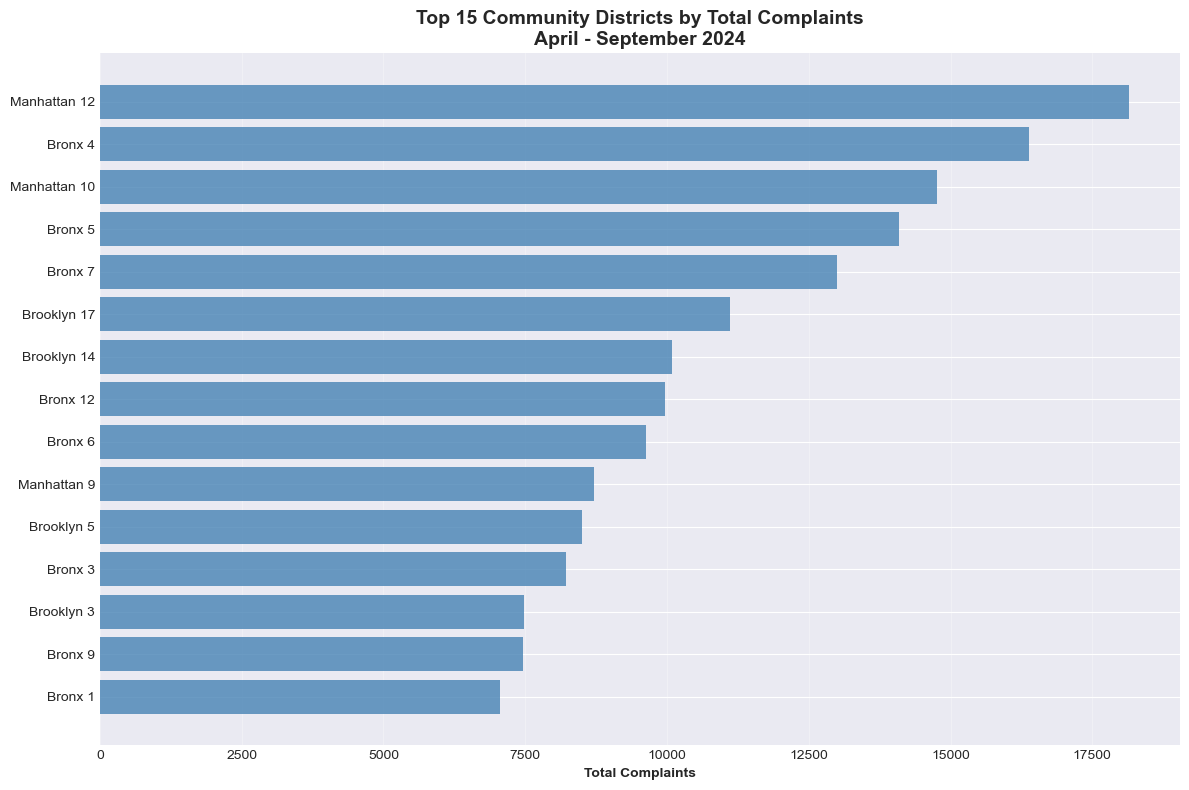


  Figure saved: Q1A_top_complaints.png


In [13]:
print("QUESTION 1A: TOP COMMUNITY DISTRICTS BY COMPLAINTS")

# Count complaints by CD
complaints_by_cd = complaints_clean.groupby('CD_Full').size().reset_index(name='Total_Complaints')
complaints_by_cd = complaints_by_cd.sort_values('Total_Complaints', ascending=False)

print("\n  Top 15 Community Districts by Total Complaints:")
print(complaints_by_cd.head(15).to_string(index=False))

print("\n\n  Bottom 10 Community Districts:")
print(complaints_by_cd.tail(10).to_string(index=False))

# Summary statistics
print("\n\n  Summary Statistics:")
print(f"  Mean: {complaints_by_cd['Total_Complaints'].mean():.1f}")
print(f"  Median: {complaints_by_cd['Total_Complaints'].median():.1f}")
print(f"  Std Dev: {complaints_by_cd['Total_Complaints'].std():.1f}")
print(f"  Min: {complaints_by_cd['Total_Complaints'].min()}")
print(f"  Max: {complaints_by_cd['Total_Complaints'].max()}")

# Quick visualization
fig, ax = plt.subplots(figsize=(12, 8))
top15 = complaints_by_cd.head(15)
ax.barh(range(len(top15)), top15['Total_Complaints'], color='steelblue', alpha=0.8)
ax.set_yticks(range(len(top15)))
ax.set_yticklabels(top15['CD_Full'])
ax.set_xlabel('Total Complaints', fontweight='bold')
ax.set_title('Top 15 Community Districts by Total Complaints\nApril - September 2024', 
            fontweight='bold', fontsize=14)
ax.invert_yaxis()
ax.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'Q1A_top_complaints.png'), dpi=300, bbox_inches='tight')
plt.show()

print(f"\n  Figure saved: Q1A_top_complaints.png")

Question 1B - Complaints Per Capita

QUESTION 1B: COMPLAINTS PER CAPITA

 Top 15 Community Districts by Complaints Per 1,000 Residents:
     CD_Full  Total_Complaints  Total Population  Complaints_Per_1000
Manhattan 10             14755            115723               127.50
     Bronx 6              9638             83268               115.75
     Bronx 4             16387            146441               111.90
     Bronx 5             14086            128200               109.88
     Bronx 2              5408             52246               103.51
     Bronx 3              8213             79762               102.97
Manhattan 12             18140            190020                95.46
     Bronx 7             12991            139286                93.27
 Manhattan 9              8720            110193                79.13
     Bronx 1              7060             91497                77.16
 Brooklyn 17             11104            155252                71.52
  Brooklyn 8              6646             96317             

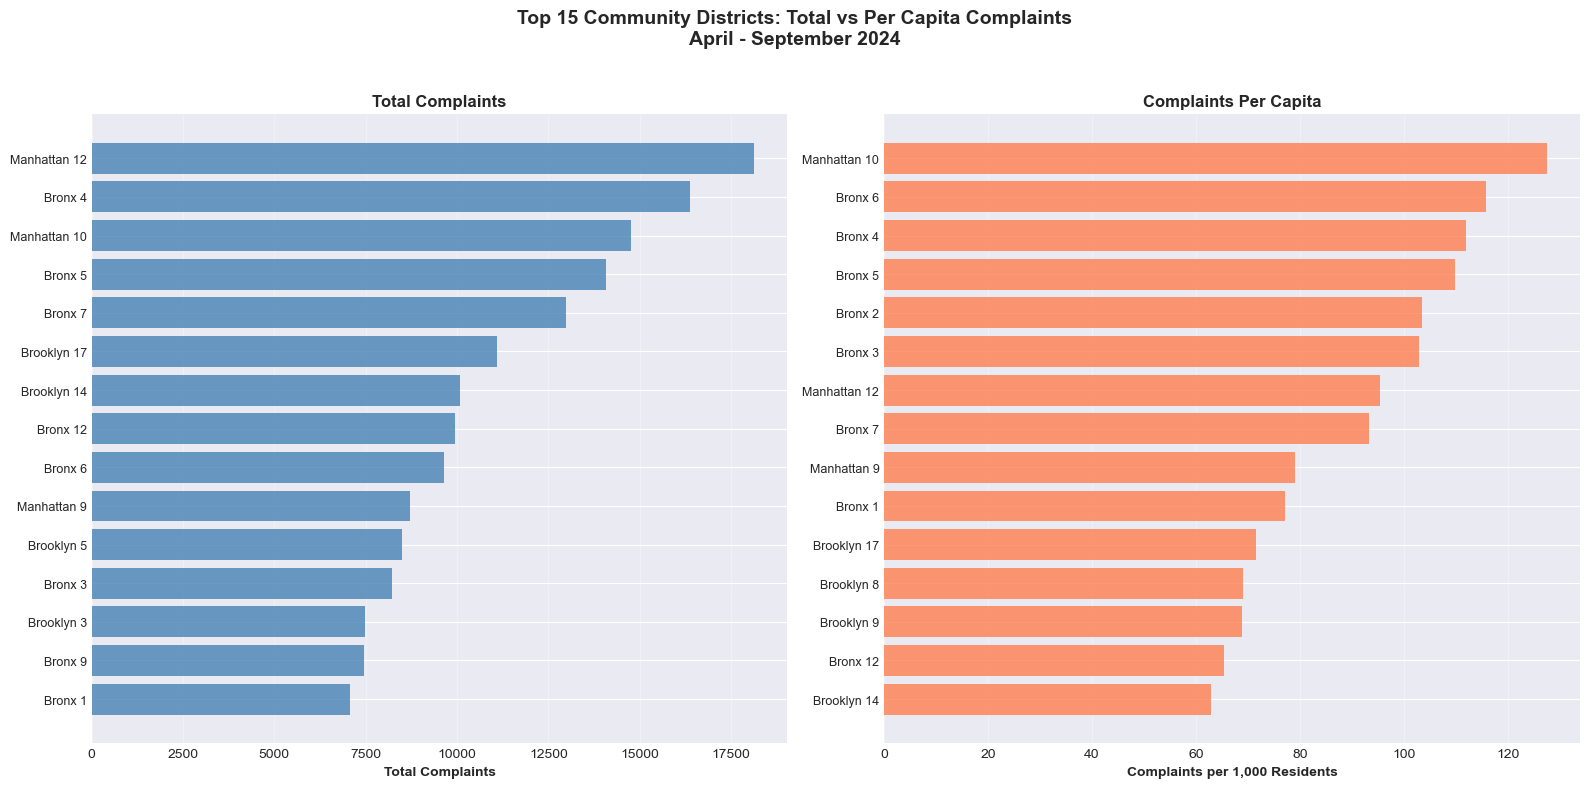


  Figure saved: Q1B_complaints_per_capita.png


In [14]:
print("QUESTION 1B: COMPLAINTS PER CAPITA")

# Merge complaints with population
complaints_per_capita = complaints_by_cd.merge(
    pop_df[['CD_Full', 'Total Population']], 
    on='CD_Full', 
    how='left'
)

# Calculate per capita (per 1,000 residents)
complaints_per_capita['Complaints_Per_1000'] = (
    complaints_per_capita['Total_Complaints'] / 
    complaints_per_capita['Total Population'] * 1000
).round(2)

# Sort by per capita
complaints_per_capita = complaints_per_capita.sort_values('Complaints_Per_1000', ascending=False)

print("\n Top 15 Community Districts by Complaints Per 1,000 Residents:")
print(complaints_per_capita[['CD_Full', 'Total_Complaints', 'Total Population', 'Complaints_Per_1000']]
      .head(15).to_string(index=False))

print("\n\n Bottom 10 Community Districts:")
print(complaints_per_capita[['CD_Full', 'Total_Complaints', 'Total Population', 'Complaints_Per_1000']]
      .tail(10).to_string(index=False))

print("\n\n Per Capita Summary Statistics:")
print(f"  Mean: {complaints_per_capita['Complaints_Per_1000'].mean():.2f} per 1,000")
print(f"  Median: {complaints_per_capita['Complaints_Per_1000'].median():.2f} per 1,000")
print(f"  Std Dev: {complaints_per_capita['Complaints_Per_1000'].std():.2f}")
print(f"  Min: {complaints_per_capita['Complaints_Per_1000'].min():.2f}")
print(f"  Max: {complaints_per_capita['Complaints_Per_1000'].max():.2f}")

# Visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# Top by total
top15_total = complaints_by_cd.head(15)
ax1.barh(range(len(top15_total)), top15_total['Total_Complaints'], color='steelblue', alpha=0.8)
ax1.set_yticks(range(len(top15_total)))
ax1.set_yticklabels(top15_total['CD_Full'], fontsize=9)
ax1.set_xlabel('Total Complaints', fontweight='bold')
ax1.set_title('Total Complaints', fontweight='bold')
ax1.invert_yaxis()
ax1.grid(True, alpha=0.3, axis='x')

# Top by per capita
top15_capita = complaints_per_capita.head(15)
ax2.barh(range(len(top15_capita)), top15_capita['Complaints_Per_1000'], color='coral', alpha=0.8)
ax2.set_yticks(range(len(top15_capita)))
ax2.set_yticklabels(top15_capita['CD_Full'], fontsize=9)
ax2.set_xlabel('Complaints per 1,000 Residents', fontweight='bold')
ax2.set_title('Complaints Per Capita', fontweight='bold')
ax2.invert_yaxis()
ax2.grid(True, alpha=0.3, axis='x')

fig.suptitle('Top 15 Community Districts: Total vs Per Capita Complaints\nApril - September 2024', 
            fontsize=14, fontweight='bold', y=0.98)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig(os.path.join(output_dir, 'Q1B_complaints_per_capita.png'), dpi=300, bbox_inches='tight')
plt.show()

print(f"\n  Figure saved: Q1B_complaints_per_capita.png")

Question 1C - Temporal Trends

QUESTION 1C: TEMPORAL TRENDS IN COMPLAINTS

 Complaints by Month:
Year_Month  Count
   2025-04  56517
   2025-05  48978
   2025-06  46981
   2025-07  52218
   2025-08  46953
   2025-09  48701


 Total Complaints by Month:
Month_Name  Count
     April  56517
       May  48978
      June  46981
      July  52218
    August  46953
 September  48701


 Month-over-Month Change:
Month_Name  Count  Pct_Change
     April  56517         NaN
       May  48978  -13.339349
      June  46981   -4.077341
      July  52218   11.147059
    August  46953  -10.082730
 September  48701    3.722872


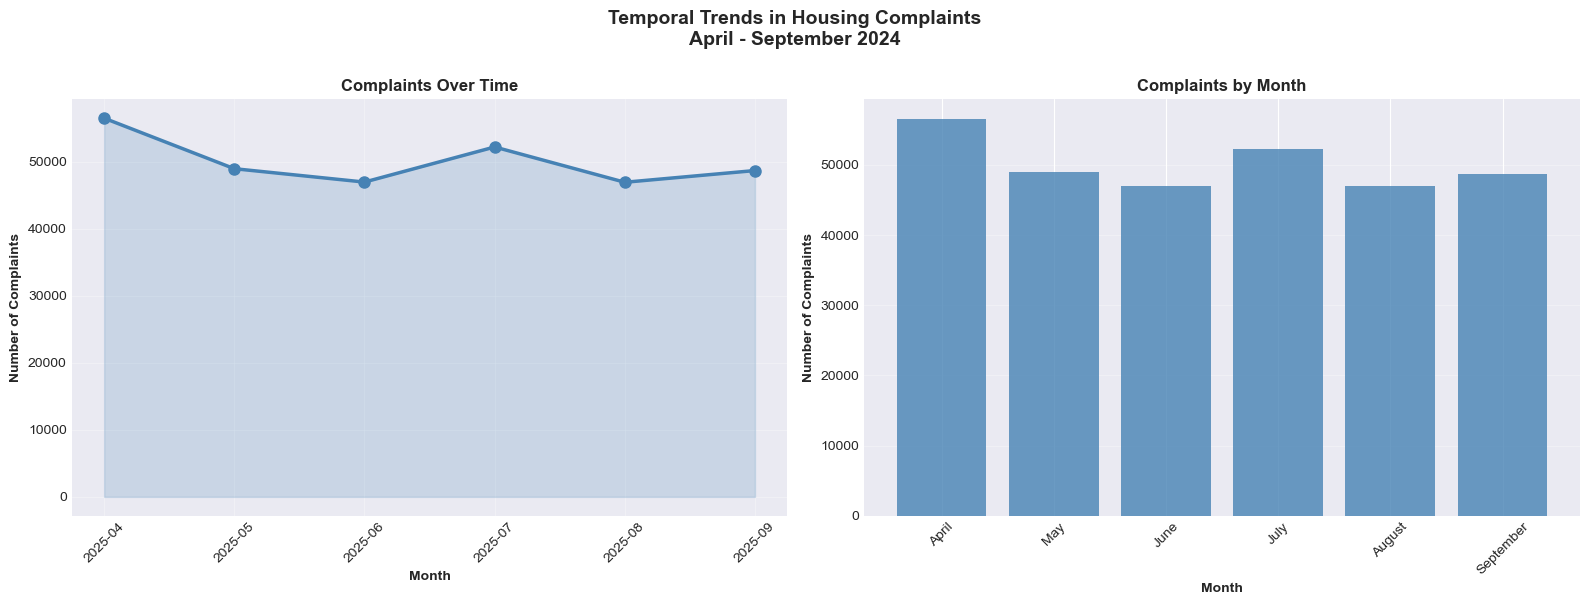


 Figure saved: Q1C_temporal_trends_complaints.png

 Overall Trend:
  First month: 56,517 complaints
  Last month: 48,701 complaints
  Change: -13.8%


In [15]:
print("QUESTION 1C: TEMPORAL TRENDS IN COMPLAINTS")

# Extract temporal features
complaints_temp = complaints_clean.copy()
complaints_temp['Year_Month'] = complaints_temp['Received Date'].dt.to_period('M')
complaints_temp['Month'] = complaints_temp['Received Date'].dt.month
complaints_temp['Month_Name'] = complaints_temp['Received Date'].dt.month_name()

# Monthly counts
monthly_counts = complaints_temp.groupby('Year_Month').size().reset_index(name='Count')
print("\n Complaints by Month:")
print(monthly_counts.to_string(index=False))

# By month name
month_order = ['April', 'May', 'June', 'July', 'August', 'September']
monthly_avg = complaints_temp.groupby('Month_Name').size().reset_index(name='Count')
monthly_avg['Month_Name'] = pd.Categorical(monthly_avg['Month_Name'], categories=month_order, ordered=True)
monthly_avg = monthly_avg.sort_values('Month_Name')

print("\n\n Total Complaints by Month:")
print(monthly_avg.to_string(index=False))

# Calculate month-over-month change
if len(monthly_avg) > 1:
    monthly_avg['Pct_Change'] = monthly_avg['Count'].pct_change() * 100
    print("\n\n Month-over-Month Change:")
    print(monthly_avg[['Month_Name', 'Count', 'Pct_Change']].to_string(index=False))

# Visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Time series
ax1.plot(range(len(monthly_counts)), monthly_counts['Count'], 
        marker='o', linewidth=2.5, markersize=8, color='steelblue')
ax1.fill_between(range(len(monthly_counts)), monthly_counts['Count'], 
                alpha=0.2, color='steelblue')
ax1.set_xticks(range(len(monthly_counts)))
ax1.set_xticklabels([str(p) for p in monthly_counts['Year_Month']], rotation=45)
ax1.set_xlabel('Month', fontweight='bold')
ax1.set_ylabel('Number of Complaints', fontweight='bold')
ax1.set_title('Complaints Over Time', fontweight='bold')
ax1.grid(True, alpha=0.3)

# By month name
ax2.bar(monthly_avg['Month_Name'], monthly_avg['Count'], color='steelblue', alpha=0.8)
ax2.set_xlabel('Month', fontweight='bold')
ax2.set_ylabel('Number of Complaints', fontweight='bold')
ax2.set_title('Complaints by Month', fontweight='bold')
ax2.tick_params(axis='x', rotation=45)
ax2.grid(True, alpha=0.3, axis='y')

fig.suptitle('Temporal Trends in Housing Complaints\nApril - September 2024', 
            fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'Q1C_temporal_trends_complaints.png'), dpi=300, bbox_inches='tight')
plt.show()

print(f"\n Figure saved: Q1C_temporal_trends_complaints.png")

# Trend analysis
if len(monthly_counts) > 1:
    overall_change = ((monthly_counts['Count'].iloc[-1] - monthly_counts['Count'].iloc[0]) / 
                     monthly_counts['Count'].iloc[0] * 100)
    print(f"\n Overall Trend:")
    print(f"  First month: {monthly_counts['Count'].iloc[0]:,} complaints")
    print(f"  Last month: {monthly_counts['Count'].iloc[-1]:,} complaints")
    print(f"  Change: {overall_change:+.1f}%")

Heat Map - CDs Over Time (Complaints)

HEAT MAP: COMPLAINTS BY CD OVER TIME


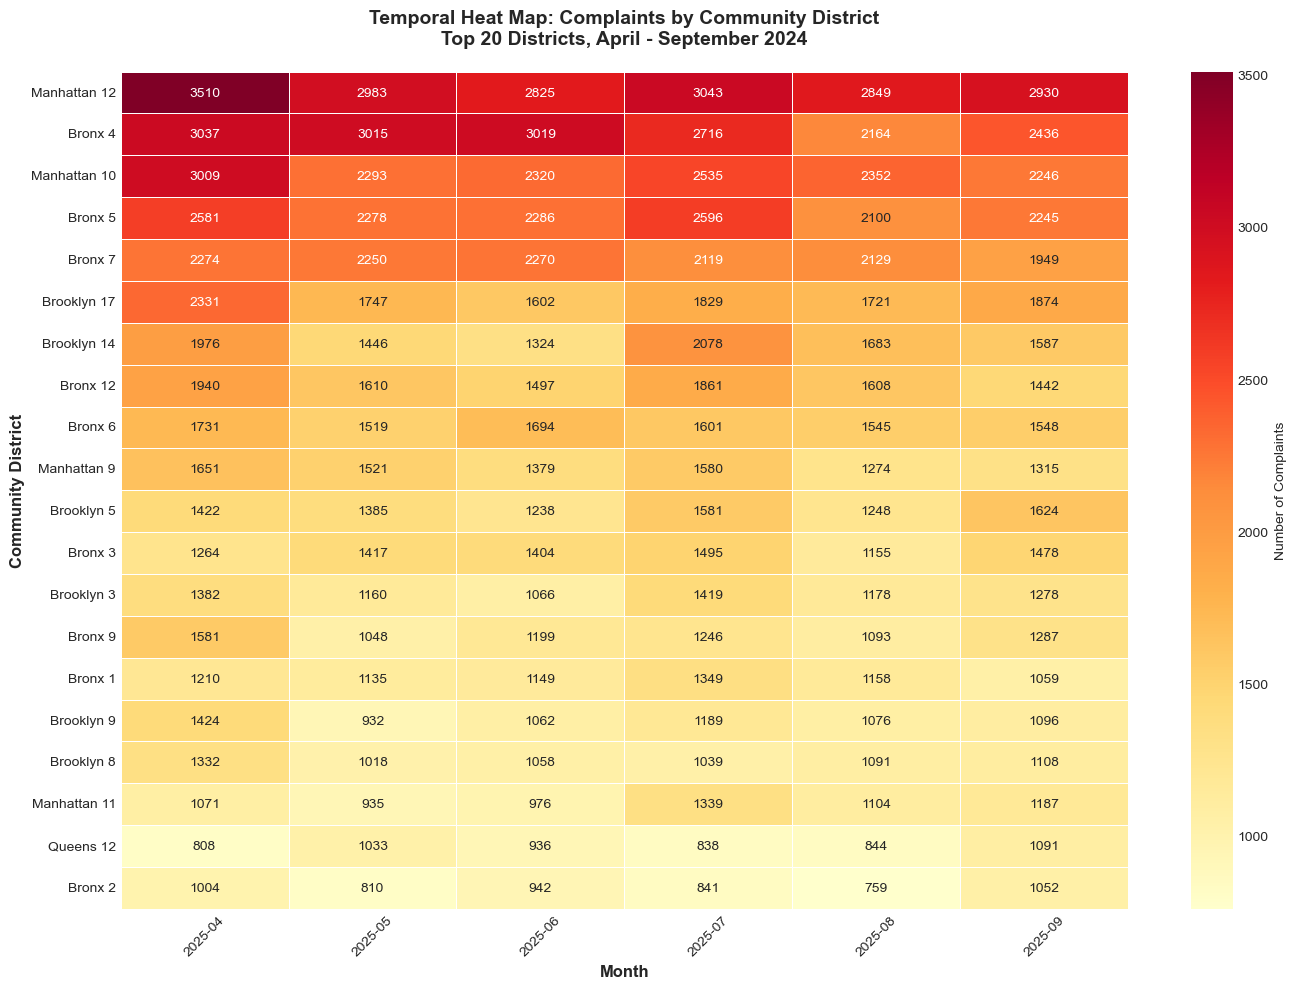


 Figure saved: heatmap_complaints_temporal.png

 Temporal Patterns:
  • Peak month: 2025-04 (56517 complaints)
  • Lowest month: 2025-08 (46953 complaints)


In [16]:
print("HEAT MAP: COMPLAINTS BY CD OVER TIME")

# Create monthly data by CD
complaints_temp = complaints_clean.copy()
complaints_temp['Year_Month'] = complaints_temp['Received Date'].dt.to_period('M').astype(str)

# Pivot table: CDs as rows, months as columns
heatmap_data = complaints_temp.groupby(['CD_Full', 'Year_Month']).size().reset_index(name='Count')
heatmap_pivot = heatmap_data.pivot(index='CD_Full', columns='Year_Month', values='Count').fillna(0)

# Get top 20 CDs by total complaints for cleaner visualization
top_cds = complaints_by_cd.head(20)['CD_Full'].tolist()
heatmap_pivot_top = heatmap_pivot.loc[top_cds]

# Create heat map
fig, ax = plt.subplots(figsize=(14, 10))
sns.heatmap(heatmap_pivot_top, 
            annot=True, 
            fmt='.0f', 
            cmap='YlOrRd', 
            cbar_kws={'label': 'Number of Complaints'},
            linewidths=0.5,
            linecolor='white',
            ax=ax)

ax.set_xlabel('Month', fontweight='bold', fontsize=12)
ax.set_ylabel('Community District', fontweight='bold', fontsize=12)
ax.set_title('Temporal Heat Map: Complaints by Community District\nTop 20 Districts, April - September 2024', 
            fontweight='bold', fontsize=14, pad=20)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'heatmap_complaints_temporal.png'), dpi=300, bbox_inches='tight')
plt.show()

print(f"\n Figure saved: heatmap_complaints_temporal.png")

# Identify hot spots
print("\n Temporal Patterns:")
max_month = heatmap_pivot.sum(axis=0).idxmax()
min_month = heatmap_pivot.sum(axis=0).idxmin()
print(f"  • Peak month: {max_month} ({heatmap_pivot.sum(axis=0).max():.0f} complaints)")
print(f"  • Lowest month: {min_month} ({heatmap_pivot.sum(axis=0).min():.0f} complaints)")

Question 2A - Violations by District

QUESTION 2A: VIOLATIONS BY COMMUNITY DISTRICT

 Top 15 Community Districts by Total Violations:
     CD_Full  Total_Violations
     Bronx 4             24538
     Bronx 5             23167
Manhattan 12             21268
     Bronx 7             20407
 Brooklyn 14             16940
     Bronx 6             16021
 Brooklyn 17             15928
Manhattan 10             15056
  Brooklyn 3             12165
    Bronx 12             12161
  Brooklyn 5             11295
     Bronx 9             11107
 Manhattan 9             10687
     Bronx 1             10654
  Brooklyn 9             10514


 Top 15 Community Districts by Violations Per 1,000 Residents:
     CD_Full  Total_Violations  Total Population  Violations_Per_1000
     Bronx 6             16021             83268               192.40
     Bronx 5             23167            128200               180.71
     Bronx 4             24538            146441               167.56
     Bronx 2              7739             52246               

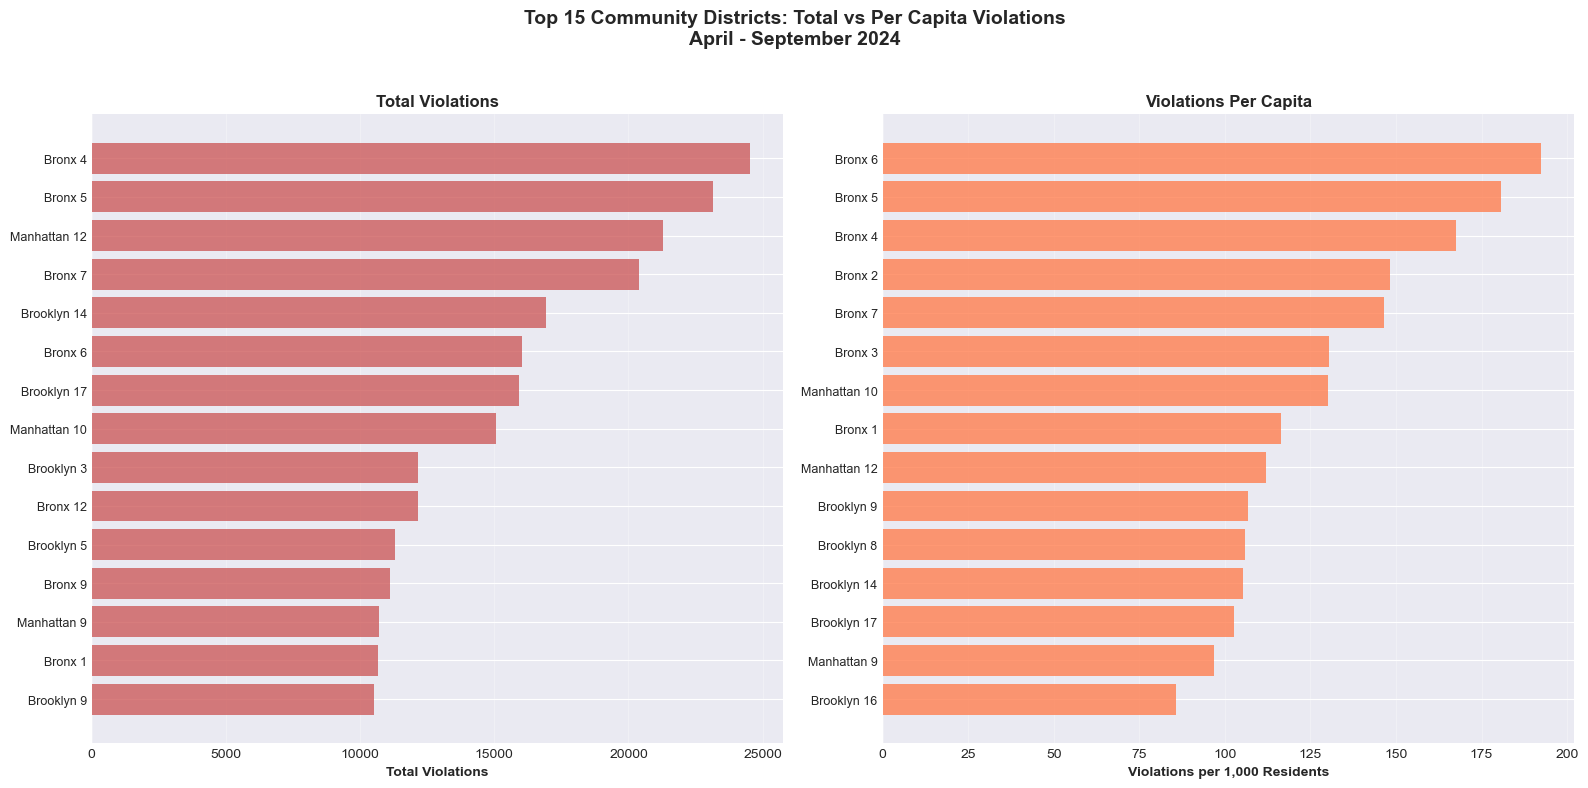


 Figure saved: Q2A_violations_per_capita.png


In [17]:
print("QUESTION 2A: VIOLATIONS BY COMMUNITY DISTRICT")

# Count violations by CD
violations_by_cd = violations_clean.groupby('CD_Full').size().reset_index(name='Total_Violations')
violations_by_cd = violations_by_cd.sort_values('Total_Violations', ascending=False)

print("\n Top 15 Community Districts by Total Violations:")
print(violations_by_cd.head(15).to_string(index=False))

# Merge with population
violations_per_capita = violations_by_cd.merge(
    pop_df[['CD_Full', 'Total Population']], 
    on='CD_Full', 
    how='left'
)

# Calculate per capita
violations_per_capita['Violations_Per_1000'] = (
    violations_per_capita['Total_Violations'] / 
    violations_per_capita['Total Population'] * 1000
).round(2)

violations_per_capita = violations_per_capita.sort_values('Violations_Per_1000', ascending=False)

print("\n\n Top 15 Community Districts by Violations Per 1,000 Residents:")
print(violations_per_capita[['CD_Full', 'Total_Violations', 'Total Population', 'Violations_Per_1000']]
      .head(15).to_string(index=False))

print("\n\n Per Capita Summary Statistics:")
print(f"  Mean: {violations_per_capita['Violations_Per_1000'].mean():.2f} per 1,000")
print(f"  Median: {violations_per_capita['Violations_Per_1000'].median():.2f} per 1,000")
print(f"  Max: {violations_per_capita['Violations_Per_1000'].max():.2f} per 1,000")

# Visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

top15_total = violations_by_cd.head(15)
ax1.barh(range(len(top15_total)), top15_total['Total_Violations'], color='indianred', alpha=0.8)
ax1.set_yticks(range(len(top15_total)))
ax1.set_yticklabels(top15_total['CD_Full'], fontsize=9)
ax1.set_xlabel('Total Violations', fontweight='bold')
ax1.set_title('Total Violations', fontweight='bold')
ax1.invert_yaxis()
ax1.grid(True, alpha=0.3, axis='x')

top15_capita = violations_per_capita.head(15)
ax2.barh(range(len(top15_capita)), top15_capita['Violations_Per_1000'], color='coral', alpha=0.8)
ax2.set_yticks(range(len(top15_capita)))
ax2.set_yticklabels(top15_capita['CD_Full'], fontsize=9)
ax2.set_xlabel('Violations per 1,000 Residents', fontweight='bold')
ax2.set_title('Violations Per Capita', fontweight='bold')
ax2.invert_yaxis()
ax2.grid(True, alpha=0.3, axis='x')

fig.suptitle('Top 15 Community Districts: Total vs Per Capita Violations\nApril - September 2024', 
            fontsize=14, fontweight='bold', y=0.98)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig(os.path.join(output_dir, 'Q2A_violations_per_capita.png'), dpi=300, bbox_inches='tight')
plt.show()

print(f"\n Figure saved: Q2A_violations_per_capita.png")

Question 2B - Violation Classes

QUESTION 2B: VIOLATION CLASSES

 Overall Violation Class Distribution:
        Count  Percentage
Class                    
B      184216       41.20
A      143909       32.18
C      117785       26.34
I        1244        0.28


 Class Definitions:
  Class A: Non-hazardous (cosmetic issues)
  Class B: Hazardous (potential health/safety risk)
  Class C: Immediately hazardous (serious threat)


 Top 10 Community Districts - Violation Counts by Class:
Class            A      B     C   I
CD_Full                            
Bronx 4       4816  12108  7563  51
Bronx 5       4227  11649  7267  24
Manhattan 12  3802  10631  6810  25
Bronx 7       4440   9681  6248  38
Brooklyn 14   4017   7605  5295  23
Bronx 6       3423   7722  4858  18
Brooklyn 17   4738   6873  4264  53
Manhattan 10  3704   6973  4340  39
Brooklyn 3    5817   4113  2210  25
Bronx 12      3922   4832  3332  75


 Top 10 Community Districts - Percentage Distribution:
Class            A     B     C    I
CD_Full               

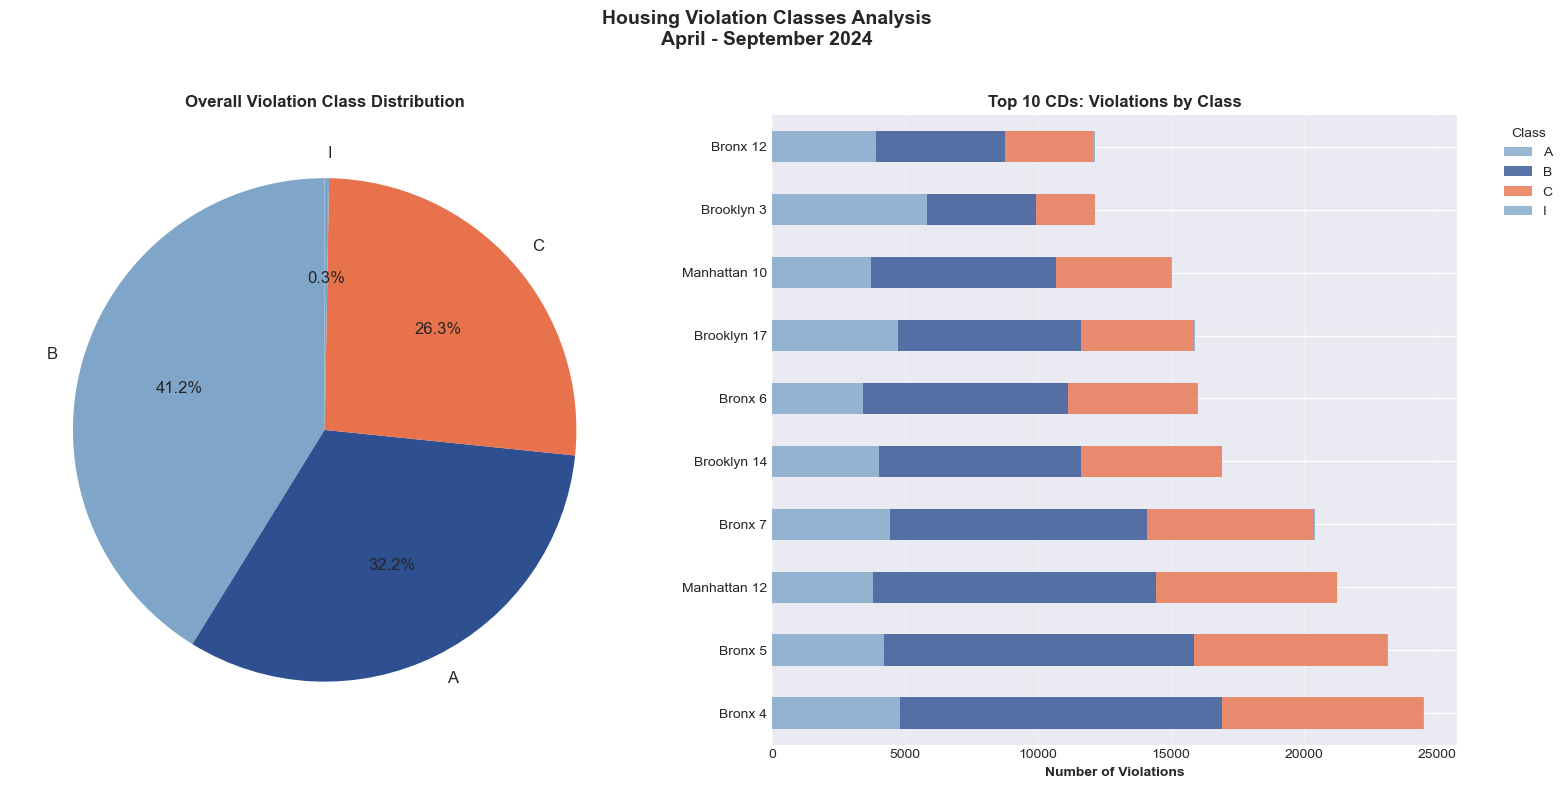


 Figure saved: Q2B_violation_classes.png


In [18]:
print("QUESTION 2B: VIOLATION CLASSES")

# Overall class distribution
class_counts = violations_clean['Class'].value_counts()
class_pct = (class_counts / class_counts.sum() * 100).round(2)

class_summary = pd.DataFrame({
    'Count': class_counts,
    'Percentage': class_pct
})

print("\n Overall Violation Class Distribution:")
print(class_summary)

print("\n\n Class Definitions:")
print("  Class A: Non-hazardous (cosmetic issues)")
print("  Class B: Hazardous (potential health/safety risk)")
print("  Class C: Immediately hazardous (serious threat)")

# By community district
class_by_cd = pd.crosstab(
    violations_clean['CD_Full'], 
    violations_clean['Class']
)

print("\n\n Top 10 Community Districts - Violation Counts by Class:")
top_10_cds = violations_clean['CD_Full'].value_counts().head(10).index
print(class_by_cd.loc[top_10_cds].to_string())

# Percentage distribution
class_pct_by_cd = pd.crosstab(
    violations_clean['CD_Full'], 
    violations_clean['Class'], 
    normalize='index'
) * 100

print("\n\n Top 10 Community Districts - Percentage Distribution:")
print(class_pct_by_cd.loc[top_10_cds].round(1).to_string())

# Visualizations
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# Pie chart
colors = ['#7FA6C9', '#2E5090', '#E8724C']
ax1.pie(class_counts, labels=class_counts.index, autopct='%1.1f%%',
       colors=colors, startangle=90, textprops={'fontsize': 12})
ax1.set_title('Overall Violation Class Distribution', fontweight='bold', fontsize=12)

# Stacked bar for top CDs
class_by_cd.loc[top_10_cds].plot(kind='barh', stacked=True, ax=ax2, 
                                 color=colors, alpha=0.8)
ax2.set_xlabel('Number of Violations', fontweight='bold')
ax2.set_ylabel('')
ax2.set_title('Top 10 CDs: Violations by Class', fontweight='bold', fontsize=12)
ax2.legend(title='Class', bbox_to_anchor=(1.05, 1), loc='upper left')
ax2.grid(True, alpha=0.3, axis='x')

fig.suptitle('Housing Violation Classes Analysis\nApril - September 2024', 
            fontsize=14, fontweight='bold', y=0.98)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig(os.path.join(output_dir, 'Q2B_violation_classes.png'), dpi=300, bbox_inches='tight')
plt.show()

print(f"\n Figure saved: Q2B_violation_classes.png")

Question 2C - Temporal Trends in Violations

QUESTION 2C: TEMPORAL TRENDS IN VIOLATIONS

 Violations by Month:
Year_Month  Count
   2025-04  54120
   2025-05  61659
   2025-06 129624
   2025-07  61272
   2025-08  65877
   2025-09  64807
   2025-10   6832
   2025-11   1063
   2025-12    620


 Total Violations by Month:
Month_Name  Count
     April  54120
       May  61659
      June 129624
      July  61272
    August  65877
 September  64807
       NaN    620
       NaN   1063
       NaN   6832


 Violations by Month and Class:
Class           A      B      C
Year_Month                     
2025-04      9665  25329  19126
2025-05     11946  29636  20077
2025-06     84165  27558  17901
2025-07     11651  30339  19282
2025-08     12480  33844  19553
2025-09     12572  32549  19686
2025-10      1315   3467   2050
2025-11        98    889     76
2025-12        17    583     20


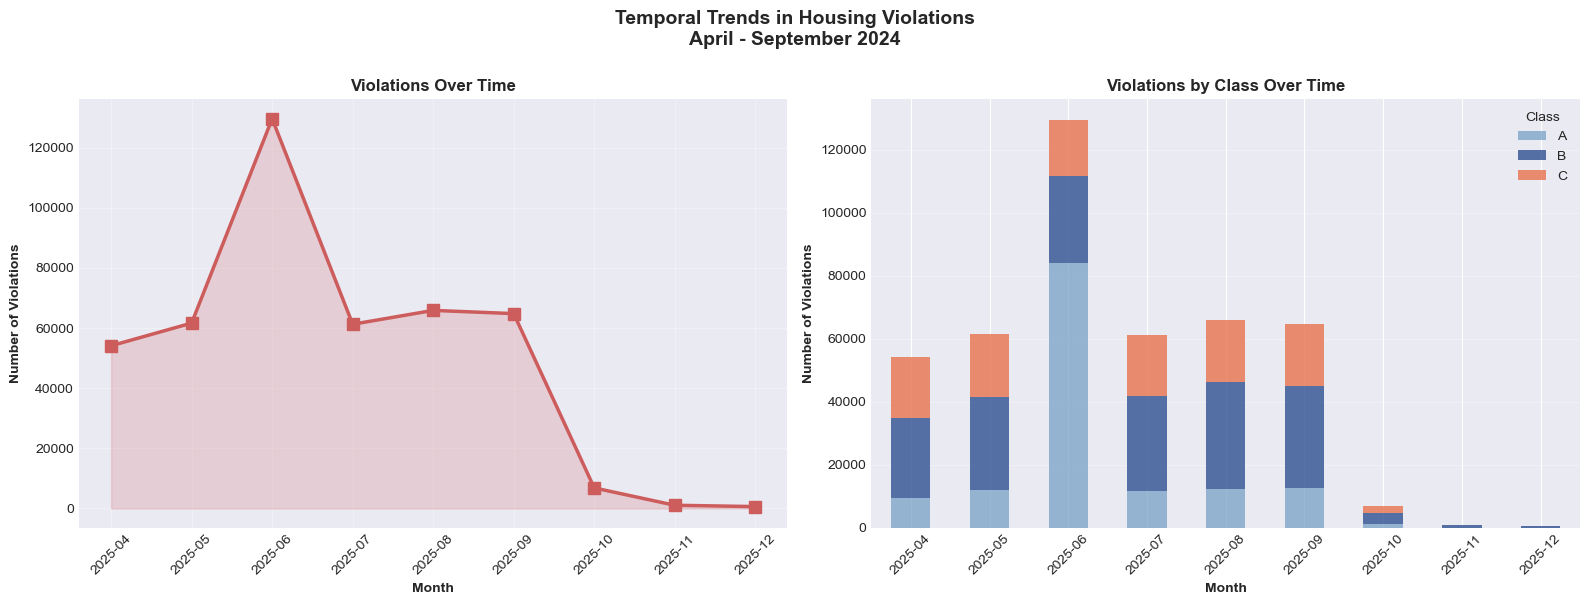


 Figure saved: Q2C_temporal_trends_violations.png


In [19]:
print("QUESTION 2C: TEMPORAL TRENDS IN VIOLATIONS")

# Extract temporal features
violations_temp = violations_clean.copy()
violations_temp['Year_Month'] = violations_temp['NOVIssuedDate'].dt.to_period('M')
violations_temp['Month_Name'] = violations_temp['NOVIssuedDate'].dt.month_name()

# Monthly counts
monthly_counts_v = violations_temp.groupby('Year_Month').size().reset_index(name='Count')
print("\n Violations by Month:")
print(monthly_counts_v.to_string(index=False))

# By month name
monthly_avg_v = violations_temp.groupby('Month_Name').size().reset_index(name='Count')
monthly_avg_v['Month_Name'] = pd.Categorical(monthly_avg_v['Month_Name'], categories=month_order, ordered=True)
monthly_avg_v = monthly_avg_v.sort_values('Month_Name')

print("\n\n Total Violations by Month:")
print(monthly_avg_v.to_string(index=False))

# By class over time
class_monthly = pd.crosstab(violations_temp['Year_Month'], violations_temp['Class'])
print("\n\n Violations by Month and Class:")
print(class_monthly.to_string())

# Visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Time series
ax1.plot(range(len(monthly_counts_v)), monthly_counts_v['Count'], 
        marker='s', linewidth=2.5, markersize=8, color='indianred')
ax1.fill_between(range(len(monthly_counts_v)), monthly_counts_v['Count'], 
                alpha=0.2, color='indianred')
ax1.set_xticks(range(len(monthly_counts_v)))
ax1.set_xticklabels([str(p) for p in monthly_counts_v['Year_Month']], rotation=45)
ax1.set_xlabel('Month', fontweight='bold')
ax1.set_ylabel('Number of Violations', fontweight='bold')
ax1.set_title('Violations Over Time', fontweight='bold')
ax1.grid(True, alpha=0.3)

# Stacked by class
class_monthly.plot(kind='bar', stacked=True, ax=ax2, color=colors, alpha=0.8)
ax2.set_xlabel('Month', fontweight='bold')
ax2.set_ylabel('Number of Violations', fontweight='bold')
ax2.set_title('Violations by Class Over Time', fontweight='bold')
ax2.set_xticklabels([str(p) for p in class_monthly.index], rotation=45)
ax2.legend(title='Class')
ax2.grid(True, alpha=0.3, axis='y')

fig.suptitle('Temporal Trends in Housing Violations\nApril - September 2024', 
            fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'Q2C_temporal_trends_violations.png'), dpi=300, bbox_inches='tight')
plt.show()

print(f"\n Figure saved: Q2C_temporal_trends_violations.png")

Heat Map - Violations by CD Over Time

HEAT MAP: VIOLATIONS BY CD OVER TIME


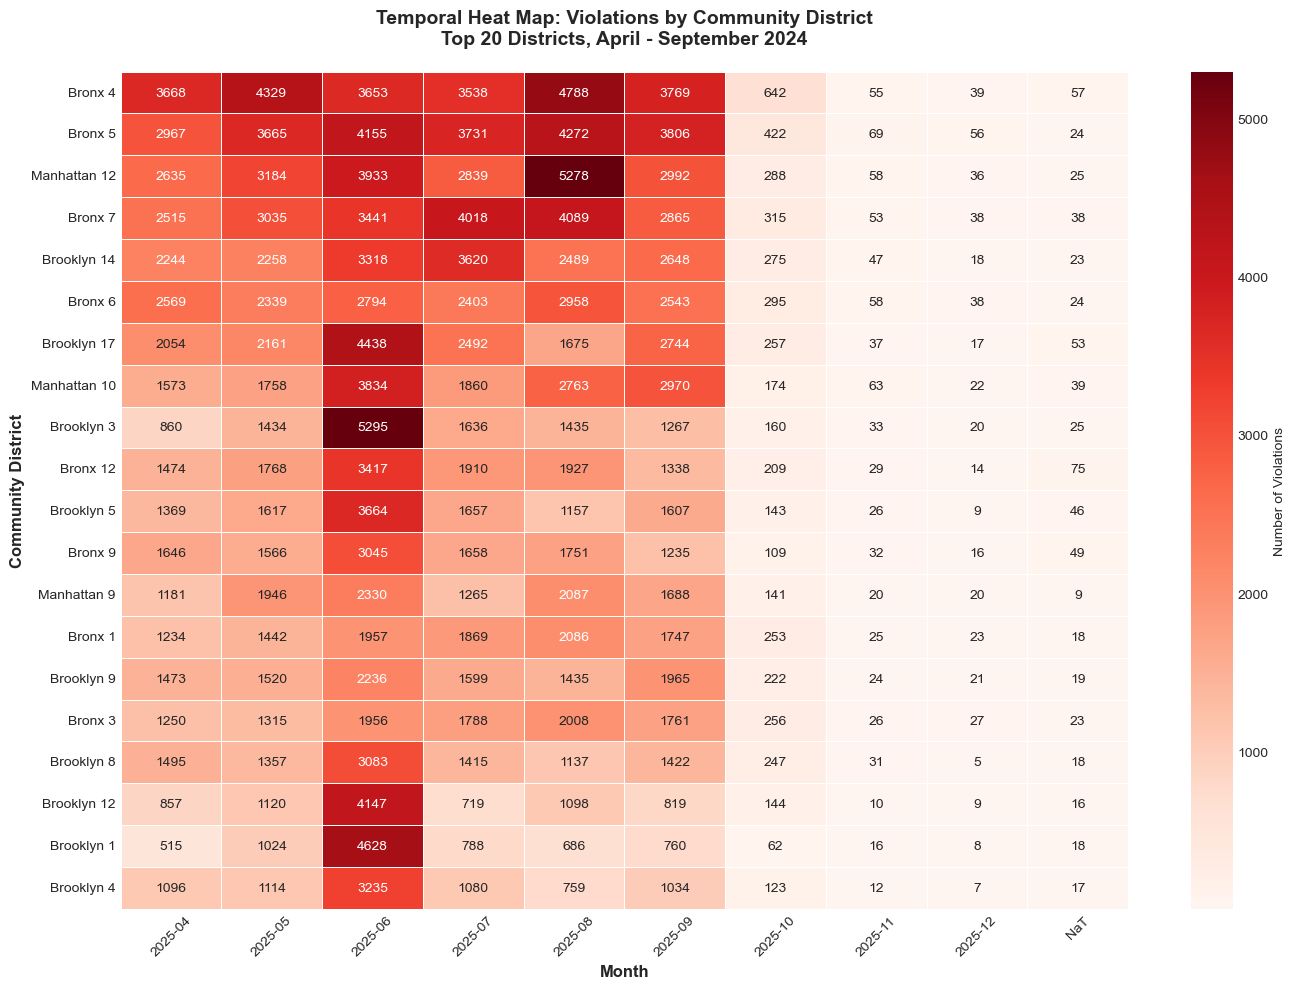


 Figure saved: heatmap_violations_temporal.png


In [20]:
print("HEAT MAP: VIOLATIONS BY CD OVER TIME")

# Create monthly data by CD
violations_temp_map = violations_clean.copy()
violations_temp_map['Year_Month'] = violations_temp_map['NOVIssuedDate'].dt.to_period('M').astype(str)

# Pivot table
heatmap_data_v = violations_temp_map.groupby(['CD_Full', 'Year_Month']).size().reset_index(name='Count')
heatmap_pivot_v = heatmap_data_v.pivot(index='CD_Full', columns='Year_Month', values='Count').fillna(0)

# Get top 20 CDs
top_cds_v = violations_by_cd.head(20)['CD_Full'].tolist()
heatmap_pivot_v_top = heatmap_pivot_v.loc[top_cds_v]

# Create heat map
fig, ax = plt.subplots(figsize=(14, 10))
sns.heatmap(heatmap_pivot_v_top, 
            annot=True, 
            fmt='.0f', 
            cmap='Reds', 
            cbar_kws={'label': 'Number of Violations'},
            linewidths=0.5,
            linecolor='white',
            ax=ax)

ax.set_xlabel('Month', fontweight='bold', fontsize=12)
ax.set_ylabel('Community District', fontweight='bold', fontsize=12)
ax.set_title('Temporal Heat Map: Violations by Community District\nTop 20 Districts, April - September 2024', 
            fontweight='bold', fontsize=14, pad=20)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'heatmap_violations_temporal.png'), dpi=300, bbox_inches='tight')
plt.show()

print(f"\n Figure saved: heatmap_violations_temporal.png")

HEAT MAP: VIOLATION CLASSES BY BOROUGH


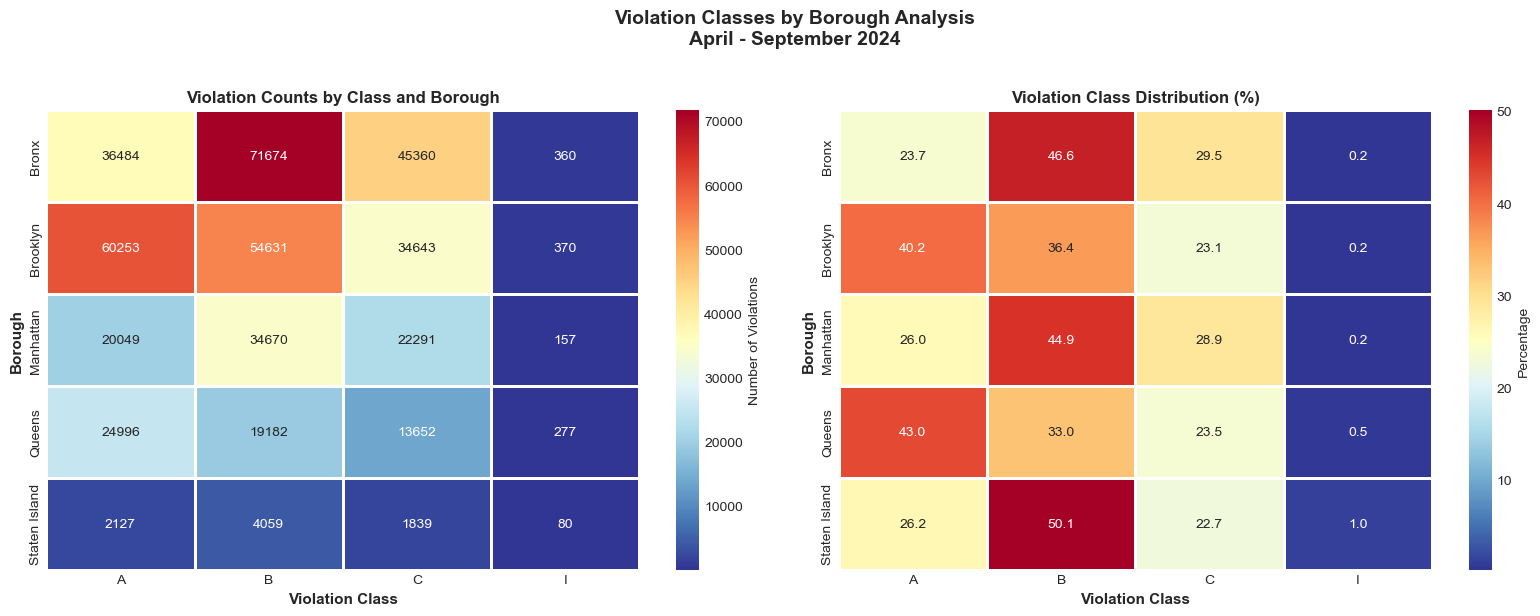


 Figure saved: heatmap_violations_class_borough.png

 Violation Class Distribution by Borough:
Class             A     B     C    I
Borough                             
Bronx          23.7  46.6  29.5  0.2
Brooklyn       40.2  36.4  23.1  0.2
Manhattan      26.0  44.9  28.9  0.2
Queens         43.0  33.0  23.5  0.5
Staten Island  26.2  50.1  22.7  1.0


In [25]:
print("HEAT MAP: VIOLATION CLASSES BY BOROUGH")

# Create crosstab with percentages
violations_class_boro = violations_clean.copy()
violations_class_boro['Borough'] = violations_class_boro['Borough'].str.strip()

# Count by borough and class
class_boro_counts = pd.crosstab(
    violations_class_boro['Borough'], 
    violations_class_boro['Class']
)

# Calculate percentages
class_boro_pct = pd.crosstab(
    violations_class_boro['Borough'], 
    violations_class_boro['Class'], 
    normalize='index'
) * 100

# Create heat map
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Counts heat map
sns.heatmap(class_boro_counts, 
            annot=True, 
            fmt='d', 
            cmap='RdYlBu_r', 
            cbar_kws={'label': 'Number of Violations'},
            linewidths=1,
            linecolor='white',
            ax=ax1)
ax1.set_xlabel('Violation Class', fontweight='bold', fontsize=11)
ax1.set_ylabel('Borough', fontweight='bold', fontsize=11)
ax1.set_title('Violation Counts by Class and Borough', fontweight='bold', fontsize=12)

# Percentage heat map
sns.heatmap(class_boro_pct, 
            annot=True, 
            fmt='.1f', 
            cmap='RdYlBu_r', 
            cbar_kws={'label': 'Percentage'},
            linewidths=1,
            linecolor='white',
            ax=ax2)
ax2.set_xlabel('Violation Class', fontweight='bold', fontsize=11)
ax2.set_ylabel('Borough', fontweight='bold', fontsize=11)
ax2.set_title('Violation Class Distribution (%)', fontweight='bold', fontsize=12)

fig.suptitle('Violation Classes by Borough Analysis\nApril - September 2024', 
            fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'heatmap_violations_class_borough.png'), dpi=300, bbox_inches='tight')
plt.show()

print(f"\n Figure saved: heatmap_violations_class_borough.png")

print("\n Violation Class Distribution by Borough:")
print(class_boro_pct.round(1))

Question 2D - Violations Per Complaint Ratio

QUESTION 2D: VIOLATIONS PER COMPLAINT RATIO

 Top 15 CDs by Violations Per Complaint Ratio:
    CD_Full  Total_Complaints  Total_Violations  Violations_Per_Complaint
Brooklyn 12              3075              8939                     2.907
 Brooklyn 6              1944              5413                     2.784
Brooklyn 10              1896              5021                     2.648
 Brooklyn 1              3693              8505                     2.303
 Brooklyn 7              2525              5748                     2.276
Brooklyn 11              3268              7439                     2.276
   Queens 5              2469              5472                     2.216
   Queens 3              2926              6227                     2.128
 Brooklyn 2              1961              3999                     2.039
Brooklyn 15              2453              4816                     1.963
   Queens 4              3048              5982                     1.963
   Queens 2         

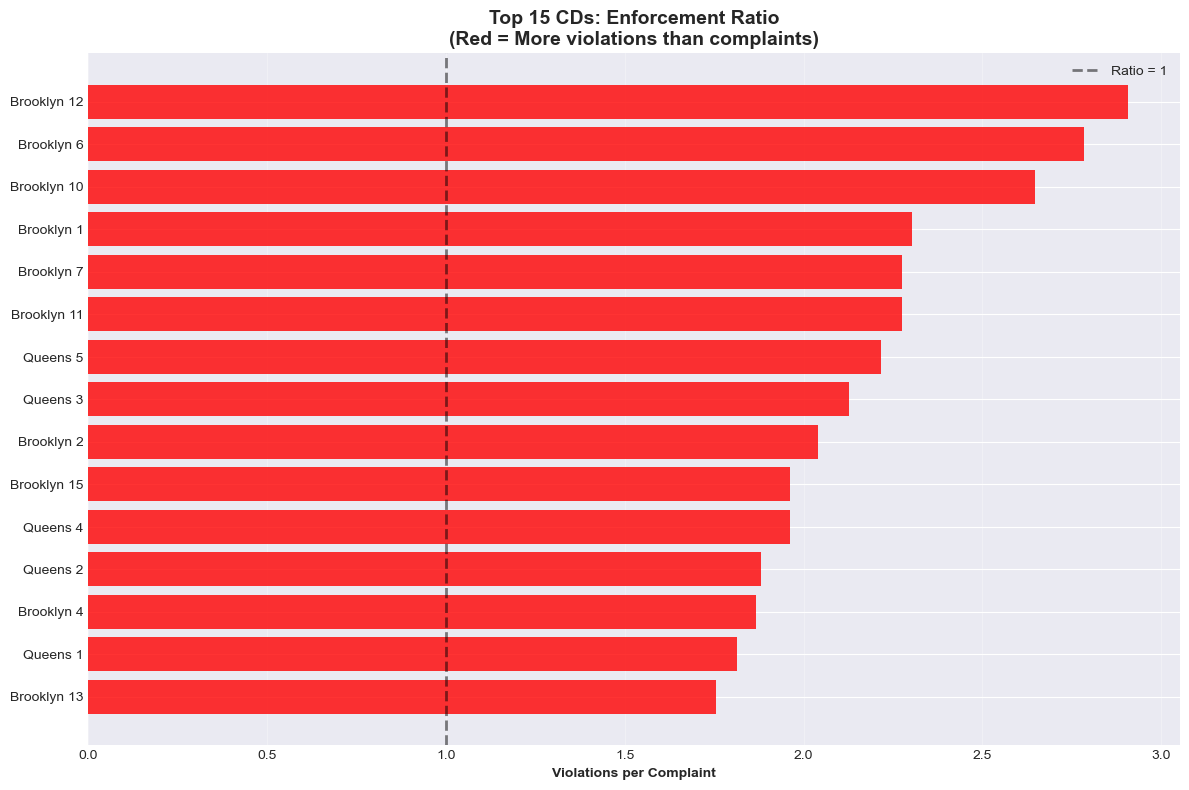


 Figure saved: Q2D_enforcement_ratio.png


In [21]:
print("QUESTION 2D: VIOLATIONS PER COMPLAINT RATIO")

# Merge complaints and violations counts
enforcement = complaints_by_cd.merge(
    violations_by_cd,
    on='CD_Full',
    how='outer'
).fillna(0)

# Calculate ratio
enforcement['Violations_Per_Complaint'] = np.where(
    enforcement['Total_Complaints'] > 0,
    (enforcement['Total_Violations'] / enforcement['Total_Complaints']).round(3),
    0
)

# Sort by ratio
enforcement = enforcement.sort_values('Violations_Per_Complaint', ascending=False)

print("\n Top 15 CDs by Violations Per Complaint Ratio:")
print(enforcement.head(15).to_string(index=False))

print("\n\n Bottom 10 CDs:")
print(enforcement.tail(10).to_string(index=False))

print("\n\n Summary Statistics:")
print(f"  Mean ratio: {enforcement['Violations_Per_Complaint'].mean():.3f}")
print(f"  Median ratio: {enforcement['Violations_Per_Complaint'].median():.3f}")
print(f"  Std Dev: {enforcement['Violations_Per_Complaint'].std():.3f}")

print("\n\n Interpretation:")
high_ratio = (enforcement['Violations_Per_Complaint'] > 1).sum()
low_ratio = (enforcement['Violations_Per_Complaint'] < 1).sum()
print(f"   {high_ratio} CDs have ratio > 1")
print("    (More violations than complaints - multiple violations per complaint)")
print(f"   {low_ratio} CDs have ratio < 1")
print("    (Not all complaints result in violations)")

# Visualization
fig, ax = plt.subplots(figsize=(12, 8))
top15 = enforcement.head(15)
colors_bar = ['red' if x > 1 else 'steelblue' for x in top15['Violations_Per_Complaint']]
ax.barh(range(len(top15)), top15['Violations_Per_Complaint'], color=colors_bar, alpha=0.8)
ax.set_yticks(range(len(top15)))
ax.set_yticklabels(top15['CD_Full'], fontsize=10)
ax.set_xlabel('Violations per Complaint', fontweight='bold')
ax.set_title('Top 15 CDs: Enforcement Ratio\n(Red = More violations than complaints)', 
            fontweight='bold', fontsize=14)
ax.axvline(x=1, color='black', linestyle='--', alpha=0.5, linewidth=2, label='Ratio = 1')
ax.invert_yaxis()
ax.legend()
ax.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'Q2D_enforcement_ratio.png'), dpi=300, bbox_inches='tight')
plt.show()

print(f"\n Figure saved: Q2D_enforcement_ratio.png")

QUESTION 3: ADDITIONAL INSIGHTS
Borough-Level Analysis

INSIGHT 1: BOROUGH-LEVEL ANALYSIS

 Borough-Level Comparison:
      Borough  Total_Complaints  Complaints_Per_1000  Total_Violations  Violations_Per_1000  Violation_Complaint_Ratio
        Bronx            103207                74.75            153878               111.45                      1.491
     Brooklyn             85679                34.21            149897                59.85                      1.750
    Manhattan             67740                42.94             77167                48.92                      1.139
       Queens             37756                16.85             58107                25.93                      1.539
Staten Island              5966                12.75              8105                17.32                      1.359


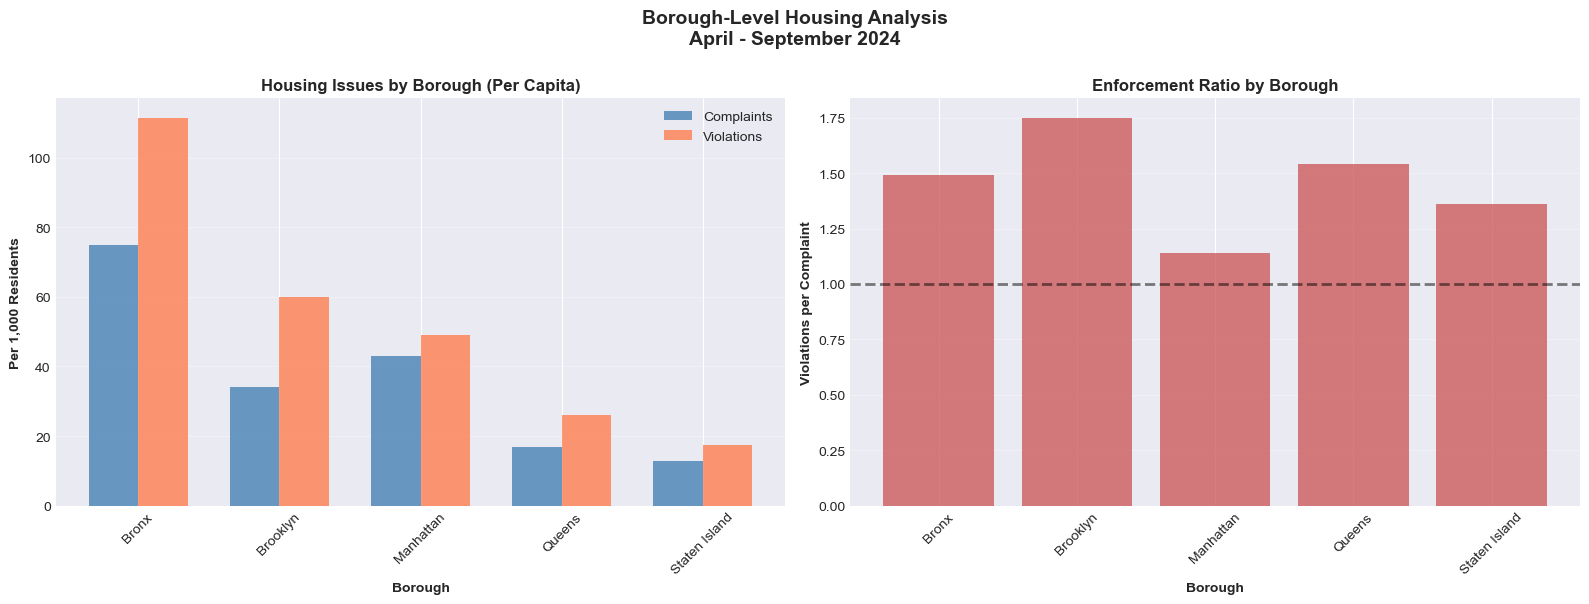


 Figure saved: Q3_borough_comparison.png


In [22]:
print("INSIGHT 1: BOROUGH-LEVEL ANALYSIS")

# Borough populations
borough_pop_total = pop_df.groupby('Borough')['Total Population'].sum().reset_index()
borough_pop_total.columns = ['Borough', 'Total_Population']

# Complaints by borough
borough_complaints = complaints_clean.groupby('Borough').size().reset_index(name='Total_Complaints')
borough_complaints = borough_complaints.merge(borough_pop_total, on='Borough')
borough_complaints['Complaints_Per_1000'] = (
    borough_complaints['Total_Complaints'] / 
    borough_complaints['Total_Population'] * 1000
).round(2)

# Violations by borough
borough_violations = violations_clean.groupby('Borough').size().reset_index(name='Total_Violations')
borough_violations = borough_violations.merge(borough_pop_total, on='Borough')
borough_violations['Violations_Per_1000'] = (
    borough_violations['Total_Violations'] / 
    borough_violations['Total_Population'] * 1000
).round(2)

# Combine
borough_comparison = borough_complaints[['Borough', 'Total_Complaints', 'Complaints_Per_1000']].merge(
    borough_violations[['Borough', 'Total_Violations', 'Violations_Per_1000']],
    on='Borough'
)

borough_comparison['Violation_Complaint_Ratio'] = (
    borough_comparison['Total_Violations'] / borough_comparison['Total_Complaints']
).round(3)

print("\n Borough-Level Comparison:")
print(borough_comparison.to_string(index=False))

# Visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

x = range(len(borough_comparison))
width = 0.35

ax1.bar([i - width/2 for i in x], borough_comparison['Complaints_Per_1000'], 
       width, label='Complaints', color='steelblue', alpha=0.8)
ax1.bar([i + width/2 for i in x], borough_comparison['Violations_Per_1000'], 
       width, label='Violations', color='coral', alpha=0.8)
ax1.set_xlabel('Borough', fontweight='bold')
ax1.set_ylabel('Per 1,000 Residents', fontweight='bold')
ax1.set_title('Housing Issues by Borough (Per Capita)', fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(borough_comparison['Borough'], rotation=45)
ax1.legend()
ax1.grid(True, alpha=0.3, axis='y')

ax2.bar(x, borough_comparison['Violation_Complaint_Ratio'], color='indianred', alpha=0.8)
ax2.set_xlabel('Borough', fontweight='bold')
ax2.set_ylabel('Violations per Complaint', fontweight='bold')
ax2.set_title('Enforcement Ratio by Borough', fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(borough_comparison['Borough'], rotation=45)
ax2.axhline(y=1, color='black', linestyle='--', alpha=0.5, linewidth=2)
ax2.grid(True, alpha=0.3, axis='y')

fig.suptitle('Borough-Level Housing Analysis\nApril - September 2024', 
            fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'Q3_borough_comparison.png'), dpi=300, bbox_inches='tight')
plt.show()

print(f"\n Figure saved: Q3_borough_comparison.png")

Box Plots - Borough Comparison

BOX PLOTS: BOROUGH DISTRIBUTIONS


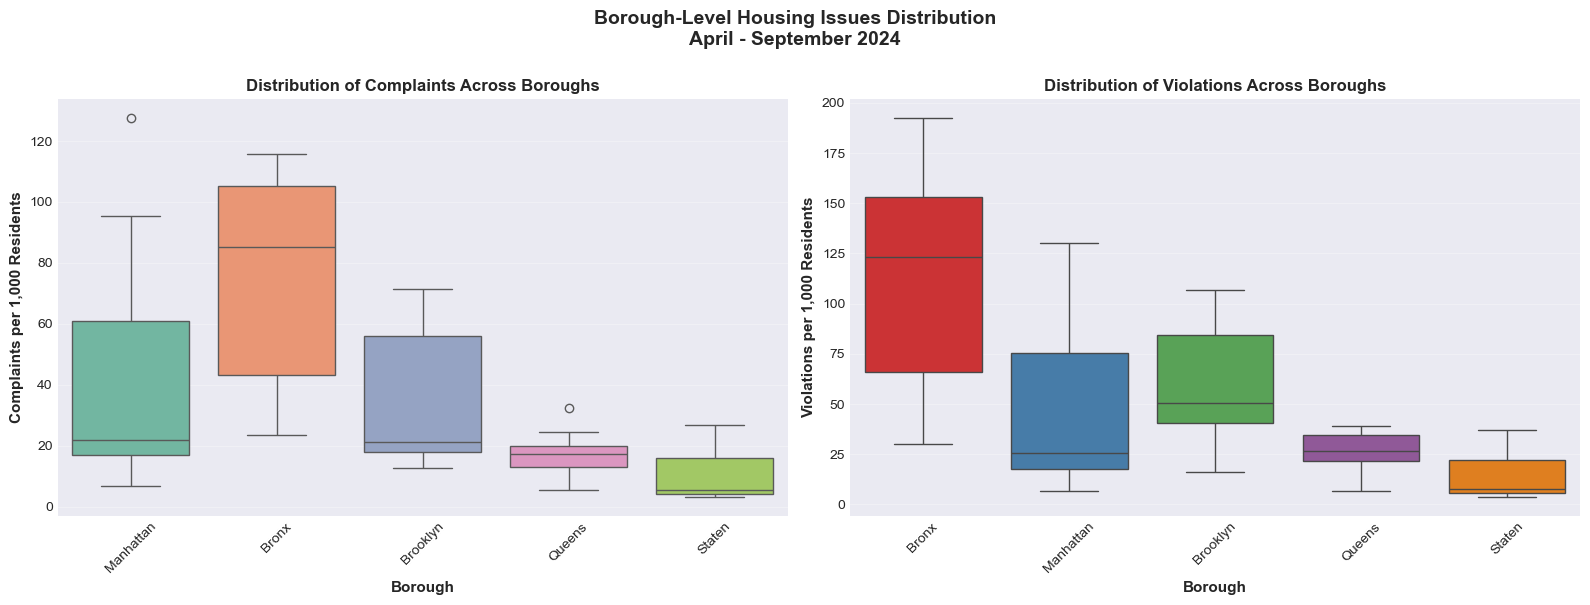


 Figure saved: boxplot_borough_distribution.png

 Distribution Statistics (Complaints Per 1,000):
            mean    50%    std    min     max
Borough                                      
Bronx      77.67  85.22  32.93  23.46  115.75
Brooklyn   35.80  21.40  22.12  12.64   71.52
Manhattan  41.94  21.74  38.90   6.77  127.50
Queens     16.96  17.36   6.85   5.51   32.37
Staten     11.86   5.38  13.07   3.30   26.90

 Distribution Statistics (Violations Per 1,000):
             mean     50%    std    min     max
Borough                                        
Bronx      115.60  123.48  53.38  30.18  192.40
Brooklyn    62.32   50.42  29.11  16.18  106.82
Manhattan   47.36   25.42  43.05   6.54  130.10
Queens      25.98   26.45  10.87   6.54   38.82
Staten      16.12    7.64  18.06   3.85   36.86


In [23]:
print("BOX PLOTS: BOROUGH DISTRIBUTIONS")

# Prepare data with borough info
complaints_box = complaints_per_capita.copy()
complaints_box['Borough'] = complaints_box['CD_Full'].str.split(' ').str[0]

violations_box = violations_per_capita.copy()
violations_box['Borough'] = violations_box['CD_Full'].str.split(' ').str[0]

# Create box plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Complaints box plot
sns.boxplot(data=complaints_box, x='Borough', y='Complaints_Per_1000', 
            palette='Set2', ax=ax1)
ax1.set_xlabel('Borough', fontweight='bold', fontsize=11)
ax1.set_ylabel('Complaints per 1,000 Residents', fontweight='bold', fontsize=11)
ax1.set_title('Distribution of Complaints Across Boroughs', fontweight='bold', fontsize=12)
ax1.tick_params(axis='x', rotation=45)
ax1.grid(True, alpha=0.3, axis='y')

# Violations box plot
sns.boxplot(data=violations_box, x='Borough', y='Violations_Per_1000', 
            palette='Set1', ax=ax2)
ax2.set_xlabel('Borough', fontweight='bold', fontsize=11)
ax2.set_ylabel('Violations per 1,000 Residents', fontweight='bold', fontsize=11)
ax2.set_title('Distribution of Violations Across Boroughs', fontweight='bold', fontsize=12)
ax2.tick_params(axis='x', rotation=45)
ax2.grid(True, alpha=0.3, axis='y')

fig.suptitle('Borough-Level Housing Issues Distribution\nApril - September 2024', 
            fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'boxplot_borough_distribution.png'), dpi=300, bbox_inches='tight')
plt.show()

print(f"\n Figure saved: boxplot_borough_distribution.png")

# Statistical summary
print("\n Distribution Statistics (Complaints Per 1,000):")
print(complaints_box.groupby('Borough')['Complaints_Per_1000'].describe()[['mean', '50%', 'std', 'min', 'max']].round(2))

print("\n Distribution Statistics (Violations Per 1,000):")
print(violations_box.groupby('Borough')['Violations_Per_1000'].describe()[['mean', '50%', 'std', 'min', 'max']].round(2))

Geographic Concentration (Gini Coefficient)

INSIGHT 2: GEOGRAPHIC CONCENTRATION

 COMPLAINTS CONCENTRATION:
  • Top 10 districts: 38.4% of all complaints
   Top 20% of districts: 42.1% of all complaints
   Gini coefficient: 0.438
    (0 = perfect equality, 1 = perfect inequality)


 VIOLATIONS CONCENTRATION:
   Top 10 districts: 35.7% of all violations
   Top 20% of districts: 38.0% of all violations
   Gini coefficient: 0.424


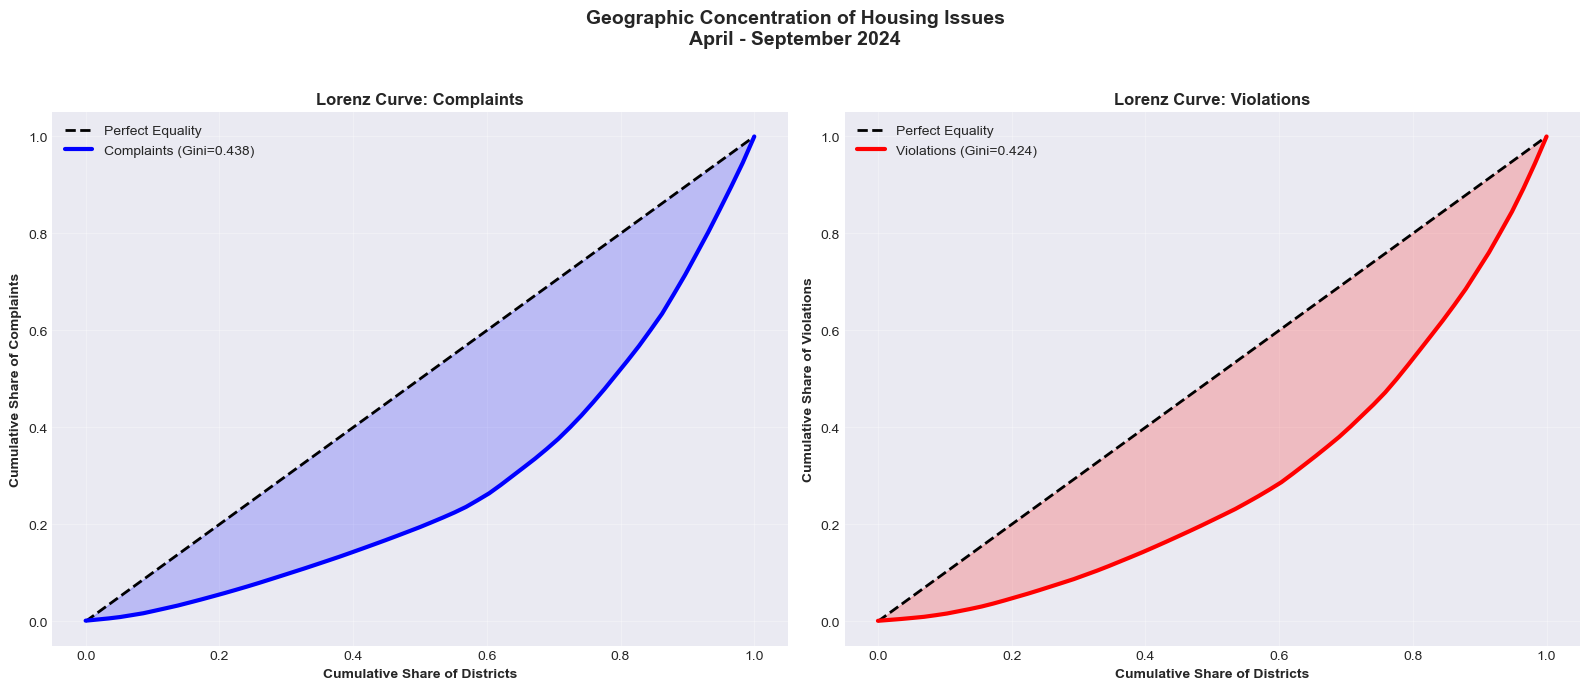


 Figure saved: Q3_concentration_lorenz.png


In [26]:
print("INSIGHT 2: GEOGRAPHIC CONCENTRATION")

def calculate_gini(array):
    """Calculate Gini coefficient"""
    array = np.sort(array)
    n = len(array)
    index = np.arange(1, n + 1)
    return (2 * np.sum(index * array)) / (n * np.sum(array)) - (n + 1) / n

# Complaints concentration
print("\n COMPLAINTS CONCENTRATION:")
total_complaints = complaints_per_capita['Total_Complaints'].sum()

top10_complaints = complaints_per_capita.head(10)['Total_Complaints'].sum()
top10_share = (top10_complaints / total_complaints * 100)
print(f"  • Top 10 districts: {top10_share:.1f}% of all complaints")

n_top20 = int(len(complaints_per_capita) * 0.2)
top20_complaints = complaints_per_capita.head(n_top20)['Total_Complaints'].sum()
top20_share = (top20_complaints / total_complaints * 100)
print(f"   Top 20% of districts: {top20_share:.1f}% of all complaints")

gini_complaints = calculate_gini(complaints_per_capita['Complaints_Per_1000'].values)
print(f"   Gini coefficient: {gini_complaints:.3f}")
print("    (0 = perfect equality, 1 = perfect inequality)")

# Violations concentration
print("\n\n VIOLATIONS CONCENTRATION:")
total_violations = violations_per_capita['Total_Violations'].sum()

top10_violations = violations_per_capita.head(10)['Total_Violations'].sum()
top10_share_v = (top10_violations / total_violations * 100)
print(f"   Top 10 districts: {top10_share_v:.1f}% of all violations")

n_top20 = int(len(violations_per_capita) * 0.2)
top20_violations = violations_per_capita.head(n_top20)['Total_Violations'].sum()
top20_share_v = (top20_violations / total_violations * 100)
print(f"   Top 20% of districts: {top20_share_v:.1f}% of all violations")

gini_violations = calculate_gini(violations_per_capita['Violations_Per_1000'].values)
print(f"   Gini coefficient: {gini_violations:.3f}")

# Visualization - Lorenz curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

# Complaints Lorenz curve
sorted_complaints = np.sort(complaints_per_capita['Complaints_Per_1000'])
cumsum = np.cumsum(sorted_complaints)
cumsum = cumsum / cumsum[-1]
x_line = np.linspace(0, 1, len(cumsum))

ax1.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Perfect Equality')
ax1.plot(x_line, cumsum, 'b-', linewidth=3, label=f'Complaints (Gini={gini_complaints:.3f})')
ax1.fill_between(x_line, cumsum, x_line, alpha=0.2, color='blue')
ax1.set_xlabel('Cumulative Share of Districts', fontweight='bold')
ax1.set_ylabel('Cumulative Share of Complaints', fontweight='bold')
ax1.set_title('Lorenz Curve: Complaints', fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Violations Lorenz curve
sorted_violations = np.sort(violations_per_capita['Violations_Per_1000'])
cumsum = np.cumsum(sorted_violations)
cumsum = cumsum / cumsum[-1]
x_line = np.linspace(0, 1, len(cumsum))

ax2.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Perfect Equality')
ax2.plot(x_line, cumsum, 'r-', linewidth=3, label=f'Violations (Gini={gini_violations:.3f})')
ax2.fill_between(x_line, cumsum, x_line, alpha=0.2, color='red')
ax2.set_xlabel('Cumulative Share of Districts', fontweight='bold')
ax2.set_ylabel('Cumulative Share of Violations', fontweight='bold')
ax2.set_title('Lorenz Curve: Violations', fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

fig.suptitle('Geographic Concentration of Housing Issues\nApril - September 2024', 
            fontsize=14, fontweight='bold', y=0.98)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig(os.path.join(output_dir, 'Q3_concentration_lorenz.png'), dpi=300, bbox_inches='tight')
plt.show()

print(f"\n Figure saved: Q3_concentration_lorenz.png")

Complaints vs Violations Relationship

INSIGHT 3: COMPLAINTS VS VIOLATIONS RELATIONSHIP

 Correlation: 0.962

 Linear Regression:
  Formula: violations = 1.356 × complaints + 5.055
  R-squared: 0.925


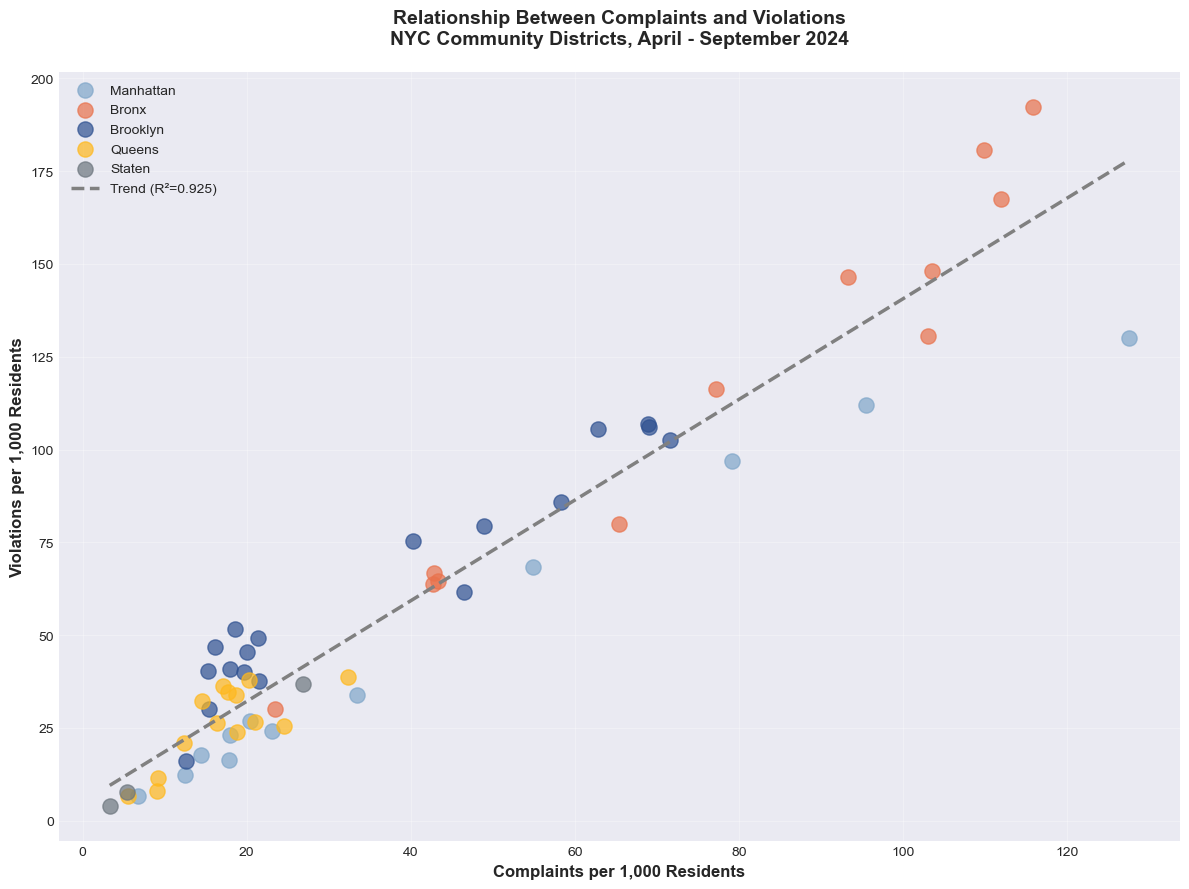


 Figure saved: Q3_complaints_vs_violations.png


 High Violation Outliers (relative to complaints):
    CD_Full  Complaints_Per_1000  Violations_Per_1000  Residual
    Bronx 6               115.75               192.40 30.359707
    Bronx 5               109.88               180.71 26.630876
 Brooklyn 6                18.57                51.70 21.459783
Brooklyn 12                16.07                46.71 19.860400
 Brooklyn 4                40.29                75.26 15.562100


In [27]:
print("INSIGHT 3: COMPLAINTS VS VIOLATIONS RELATIONSHIP")

# Merge datasets
relationship = complaints_per_capita[['CD_Full', 'Complaints_Per_1000']].merge(
    violations_per_capita[['CD_Full', 'Violations_Per_1000']],
    on='CD_Full',
    how='inner'
)

# Calculate correlation
correlation = relationship['Complaints_Per_1000'].corr(relationship['Violations_Per_1000'])
print(f"\n Correlation: {correlation:.3f}")

# Extract borough for coloring
relationship['Borough'] = relationship['CD_Full'].str.split(' ').str[0]

# Regression line
z = np.polyfit(relationship['Complaints_Per_1000'], relationship['Violations_Per_1000'], 1)
p = np.poly1d(z)

print(f"\n Linear Regression:")
print(f"  Formula: violations = {z[0]:.3f} × complaints + {z[1]:.3f}")
print(f"  R-squared: {correlation**2:.3f}")

# Visualization
fig, ax = plt.subplots(figsize=(12, 9))

borough_colors_map = {
    'Bronx': '#E8724C',
    'Brooklyn': '#2E5090',
    'Manhattan': '#7FA6C9',
    'Queens': '#FFB81C',
    'Staten': '#6C757D'
}

for borough in relationship['Borough'].unique():
    borough_data = relationship[relationship['Borough'] == borough]
    ax.scatter(borough_data['Complaints_Per_1000'], 
              borough_data['Violations_Per_1000'],
              s=120, alpha=0.7, 
              label=borough,
              color=borough_colors_map.get(borough, '#000000'))

# Add trend line
x_line = np.linspace(relationship['Complaints_Per_1000'].min(), 
                    relationship['Complaints_Per_1000'].max(), 100)
ax.plot(x_line, p(x_line), "--", color='gray', linewidth=2.5, 
       label=f'Trend (R²={correlation**2:.3f})')

ax.set_xlabel('Complaints per 1,000 Residents', fontweight='bold', fontsize=12)
ax.set_ylabel('Violations per 1,000 Residents', fontweight='bold', fontsize=12)
ax.set_title('Relationship Between Complaints and Violations\nNYC Community Districts, April - September 2024', 
            fontweight='bold', fontsize=14, pad=20)
ax.legend(loc='upper left', fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'Q3_complaints_vs_violations.png'), dpi=300, bbox_inches='tight')
plt.show()

print(f"\n Figure saved: Q3_complaints_vs_violations.png")

# Find outliers
relationship['Residual'] = relationship['Violations_Per_1000'] - p(relationship['Complaints_Per_1000'])
outliers = relationship.nlargest(5, 'Residual')[['CD_Full', 'Complaints_Per_1000', 'Violations_Per_1000', 'Residual']]
print("\n\n High Violation Outliers (relative to complaints):")
print(outliers.to_string(index=False))

Summary Dashboard

CREATING SUMMARY DASHBOARD


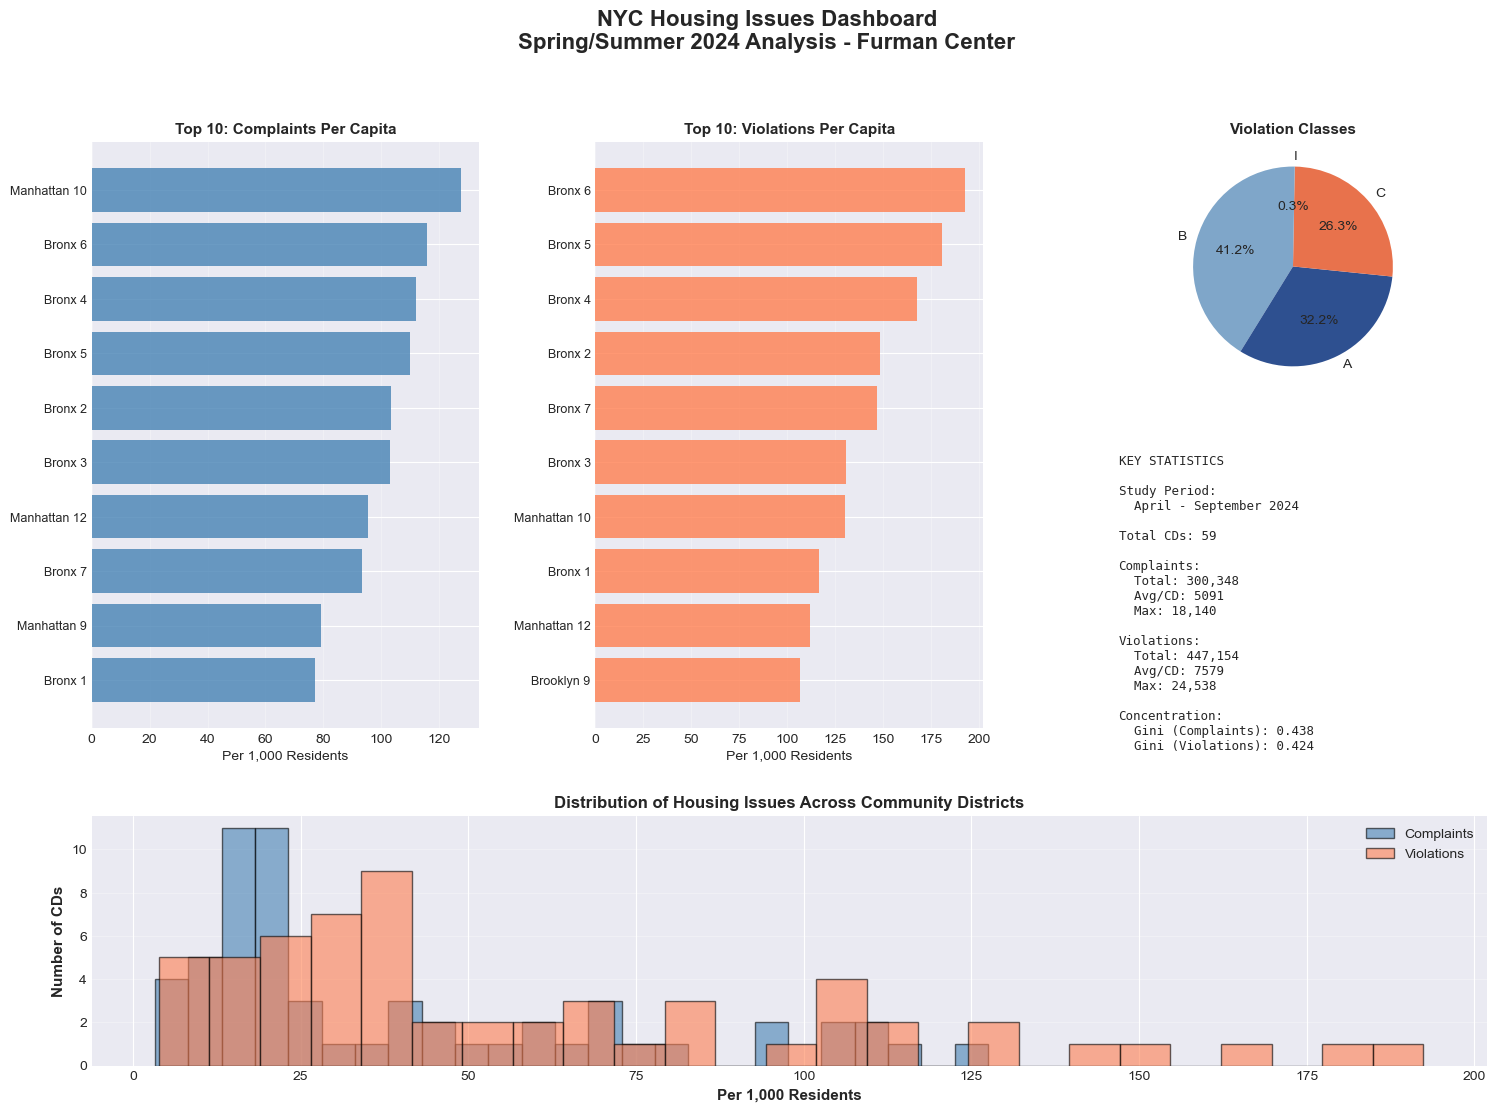


 Dashboard saved: summary_dashboard.png


In [28]:
print("CREATING SUMMARY DASHBOARD")

fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(3, 3, hspace=0.35, wspace=0.3)

# 1. Top CDs - Complaints
ax1 = fig.add_subplot(gs[0:2, 0])
top10_c = complaints_per_capita.nlargest(10, 'Complaints_Per_1000')
y_pos = np.arange(len(top10_c))
ax1.barh(y_pos, top10_c['Complaints_Per_1000'], color='steelblue', alpha=0.8)
ax1.set_yticks(y_pos)
ax1.set_yticklabels(top10_c['CD_Full'], fontsize=9)
ax1.set_xlabel('Per 1,000 Residents', fontsize=10)
ax1.set_title('Top 10: Complaints Per Capita', fontweight='bold', fontsize=11)
ax1.invert_yaxis()
ax1.grid(True, alpha=0.3, axis='x')

# 2. Top CDs - Violations
ax2 = fig.add_subplot(gs[0:2, 1])
top10_v = violations_per_capita.nlargest(10, 'Violations_Per_1000')
ax2.barh(y_pos, top10_v['Violations_Per_1000'], color='coral', alpha=0.8)
ax2.set_yticks(y_pos)
ax2.set_yticklabels(top10_v['CD_Full'], fontsize=9)
ax2.set_xlabel('Per 1,000 Residents', fontsize=10)
ax2.set_title('Top 10: Violations Per Capita', fontweight='bold', fontsize=11)
ax2.invert_yaxis()
ax2.grid(True, alpha=0.3, axis='x')

# 3. Violation classes pie
ax3 = fig.add_subplot(gs[0, 2])
colors_pie = ['#7FA6C9', '#2E5090', '#E8724C']
ax3.pie(class_counts, labels=class_counts.index, autopct='%1.1f%%',
       colors=colors_pie, startangle=90)
ax3.set_title('Violation Classes', fontweight='bold', fontsize=11)

# 4. Key statistics
ax4 = fig.add_subplot(gs[1, 2])
ax4.axis('off')
stats_text = f"""
KEY STATISTICS

Study Period:
  April - September 2024

Total CDs: {len(complaints_per_capita)}

Complaints:
  Total: {complaints_per_capita['Total_Complaints'].sum():,}
  Avg/CD: {complaints_per_capita['Total_Complaints'].mean():.0f}
  Max: {complaints_per_capita['Total_Complaints'].max():,}

Violations:
  Total: {violations_per_capita['Total_Violations'].sum():,}
  Avg/CD: {violations_per_capita['Total_Violations'].mean():.0f}
  Max: {violations_per_capita['Total_Violations'].max():,}

Concentration:
  Gini (Complaints): {gini_complaints:.3f}
  Gini (Violations): {gini_violations:.3f}
"""
ax4.text(0.05, 0.5, stats_text, fontsize=9, family='monospace',
        verticalalignment='center')

# 5. Distribution histogram
ax5 = fig.add_subplot(gs[2, :])
ax5.hist(complaints_per_capita['Complaints_Per_1000'], bins=25, 
        alpha=0.6, label='Complaints', color='steelblue', edgecolor='black')
ax5.hist(violations_per_capita['Violations_Per_1000'], bins=25, 
        alpha=0.6, label='Violations', color='coral', edgecolor='black')
ax5.set_xlabel('Per 1,000 Residents', fontweight='bold', fontsize=11)
ax5.set_ylabel('Number of CDs', fontweight='bold', fontsize=11)
ax5.set_title('Distribution of Housing Issues Across Community Districts', 
             fontweight='bold', fontsize=12)
ax5.legend(fontsize=10)
ax5.grid(True, alpha=0.3, axis='y')

fig.suptitle('NYC Housing Issues Dashboard\nSpring/Summer 2024 Analysis - Furman Center', 
            fontsize=16, fontweight='bold', y=0.99)

plt.savefig(os.path.join(output_dir, 'summary_dashboard.png'), 
           dpi=300, bbox_inches='tight')
plt.show()

print(f"\n Dashboard saved: summary_dashboard.png")

Final Summary

In [30]:
print("ANALYSIS COMPLETE!")

print("\n KEY FINDINGS:")

# Top complaints CD
top_complaint_cd = complaints_per_capita.iloc[0]
print(f"\n1. Highest complaints per capita:")
print(f"   {top_complaint_cd['CD_Full']}: {top_complaint_cd['Complaints_Per_1000']:.2f} per 1,000")

# Top violations CD
top_violation_cd = violations_per_capita.iloc[0]
print(f"\n2. Highest violations per capita:")
print(f"   {top_violation_cd['CD_Full']}: {top_violation_cd['Violations_Per_1000']:.2f} per 1,000")

# Most common violation class
print(f"\n3. Most common violation class:")
print(f"   Class {class_counts.index[0]}: {class_pct.iloc[0]:.1f}%")

# Temporal trend
if len(monthly_counts) > 1:
    trend_pct = ((monthly_counts['Count'].iloc[-1] - monthly_counts['Count'].iloc[0]) / 
                 monthly_counts['Count'].iloc[0] * 100)
    print(f"\n4. Temporal trend (Apr to Sep):")
    print(f"   {trend_pct:+.1f}% change in complaints")

# Correlation
print(f"\n5. Complaints vs Violations correlation:")
print(f"   R = {correlation:.3f} (R² = {correlation**2:.3f})")

# Concentration
print(f"\n6. Geographic concentration:")
print(f"   Top 10 CDs account for {top10_share:.1f}% of all complaints")

print("OUTPUT FILES CREATED:")

output_files = [f for f in os.listdir(output_dir) if f.endswith('.png')]
for i, fname in enumerate(sorted(output_files), 1):
    fpath = os.path.join(output_dir, fname)
    size_kb = os.path.getsize(fpath) / 1024
    print(f"{i}. {fname} ({size_kb:.1f} KB)")

print(f"\n All files saved to: {output_dir}")

ANALYSIS COMPLETE!

 KEY FINDINGS:

1. Highest complaints per capita:
   Manhattan 10: 127.50 per 1,000

2. Highest violations per capita:
   Bronx 6: 192.40 per 1,000

3. Most common violation class:
   Class B: 41.2%

4. Temporal trend (Apr to Sep):
   -13.8% change in complaints

5. Complaints vs Violations correlation:
   R = 0.962 (R² = 0.925)

6. Geographic concentration:
   Top 10 CDs account for 38.4% of all complaints
OUTPUT FILES CREATED:
1. Q1A_top_complaints.png (163.6 KB)
2. Q1B_complaints_per_capita.png (244.0 KB)
3. Q1C_temporal_trends_complaints.png (231.7 KB)
4. Q2A_violations_per_capita.png (248.4 KB)
5. Q2B_violation_classes.png (261.6 KB)
6. Q2C_temporal_trends_violations.png (241.3 KB)
7. Q2D_enforcement_ratio.png (182.9 KB)
8. Q3_borough_comparison.png (224.8 KB)
9. Q3_complaints_vs_violations.png (391.3 KB)
10. Q3_concentration_lorenz.png (382.3 KB)
11. boxplot_borough_distribution.png (232.6 KB)
12. heatmap_complaints_temporal.png (572.4 KB)
13. heatmap_violatio